In [0]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D, Conv2DTranspose
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.datasets import cifar10

import matplotlib.pyplot as plt
import tensorflow as tf
import sys

import numpy as np

In [0]:
class DCGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(256 * 7 * 7, activation="relu", input_dim=self.latent_dim))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Reshape((7, 7, 256)))
        
        model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        
        model.add(Conv2DTranspose(64, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        
        model.add(Conv2DTranspose(32, kernel_size=3, padding='same'))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation('relu'))
        
        model.add(Conv2D(self.channels, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):
        
        dropout = 0.4
        
        model = Sequential()

        model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(dropout))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(dropout))
        model.add(Conv2D(256, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(dropout))
        model.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(dropout))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, save_interval=50):

        (X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1)) # For real data the label is one [1, 1, 1, 1, 1, 1]
        fake = np.zeros((batch_size, 1)) # For fake data the label is zero [0, 0, 0, 0, 0, 0]

        for epoch in range(epochs):
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            if epoch % save_interval == 0:
                self.save_imgs(epoch)

    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        plt.show()
        plt.close()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 7, 7, 128)         73856     
_________________________________________________________________
batch_normalization_18 (Batc (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 7, 7, 128)         0         
__________

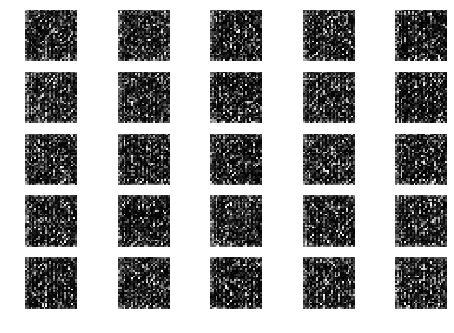

1 [D loss: 0.660508, acc.: 62.50%] [G loss: 1.499923]
2 [D loss: 0.427371, acc.: 85.94%] [G loss: 2.170830]
3 [D loss: 0.390227, acc.: 79.69%] [G loss: 2.060380]
4 [D loss: 0.339694, acc.: 85.94%] [G loss: 2.009709]
5 [D loss: 0.428246, acc.: 78.12%] [G loss: 2.577332]
6 [D loss: 0.362022, acc.: 78.12%] [G loss: 2.927390]
7 [D loss: 0.258178, acc.: 89.06%] [G loss: 3.278178]
8 [D loss: 0.326117, acc.: 87.50%] [G loss: 2.721490]
9 [D loss: 0.298131, acc.: 85.94%] [G loss: 2.671853]
10 [D loss: 0.214948, acc.: 90.62%] [G loss: 2.690167]
11 [D loss: 0.253933, acc.: 89.06%] [G loss: 2.653809]
12 [D loss: 0.381395, acc.: 84.38%] [G loss: 3.222565]
13 [D loss: 0.506556, acc.: 76.56%] [G loss: 3.347779]
14 [D loss: 0.305434, acc.: 84.38%] [G loss: 3.050436]
15 [D loss: 0.302294, acc.: 84.38%] [G loss: 3.407884]
16 [D loss: 0.290314, acc.: 85.94%] [G loss: 3.152233]
17 [D loss: 0.231877, acc.: 85.94%] [G loss: 3.750964]
18 [D loss: 0.415981, acc.: 79.69%] [G loss: 3.572463]
19 [D loss: 0.32788

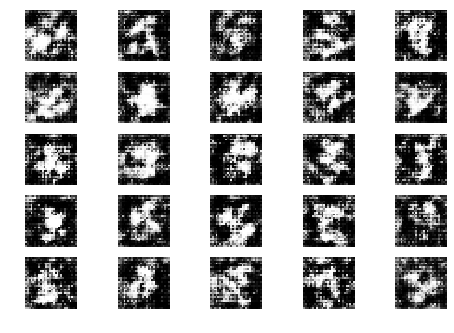

51 [D loss: 1.211415, acc.: 51.56%] [G loss: 2.891571]
52 [D loss: 1.221827, acc.: 45.31%] [G loss: 3.017053]
53 [D loss: 1.053462, acc.: 57.81%] [G loss: 3.316060]
54 [D loss: 0.993097, acc.: 54.69%] [G loss: 3.118025]
55 [D loss: 0.995777, acc.: 51.56%] [G loss: 2.038077]
56 [D loss: 0.823418, acc.: 65.62%] [G loss: 3.102627]
57 [D loss: 0.650838, acc.: 70.31%] [G loss: 2.422092]
58 [D loss: 0.570774, acc.: 67.19%] [G loss: 2.319426]
59 [D loss: 0.914949, acc.: 57.81%] [G loss: 1.508339]
60 [D loss: 0.573514, acc.: 76.56%] [G loss: 1.694111]
61 [D loss: 0.892231, acc.: 57.81%] [G loss: 1.703867]
62 [D loss: 1.293135, acc.: 40.62%] [G loss: 2.389544]
63 [D loss: 1.186234, acc.: 50.00%] [G loss: 2.312267]
64 [D loss: 1.198196, acc.: 50.00%] [G loss: 2.353917]
65 [D loss: 0.963995, acc.: 50.00%] [G loss: 1.887453]
66 [D loss: 0.657551, acc.: 60.94%] [G loss: 2.946662]
67 [D loss: 0.902813, acc.: 56.25%] [G loss: 2.662985]
68 [D loss: 1.094581, acc.: 43.75%] [G loss: 2.411889]
69 [D loss

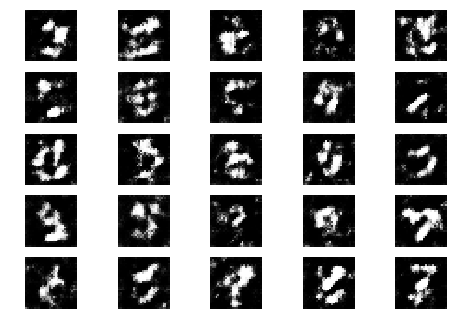

101 [D loss: 1.221838, acc.: 46.88%] [G loss: 1.964982]
102 [D loss: 0.964102, acc.: 50.00%] [G loss: 1.718992]
103 [D loss: 1.413130, acc.: 31.25%] [G loss: 1.422768]
104 [D loss: 1.008781, acc.: 40.62%] [G loss: 1.431237]
105 [D loss: 1.314783, acc.: 43.75%] [G loss: 1.378301]
106 [D loss: 0.998639, acc.: 50.00%] [G loss: 1.985026]
107 [D loss: 1.205277, acc.: 40.62%] [G loss: 1.561798]
108 [D loss: 1.113338, acc.: 45.31%] [G loss: 1.594360]
109 [D loss: 1.514107, acc.: 34.38%] [G loss: 1.213081]
110 [D loss: 0.827859, acc.: 59.38%] [G loss: 1.788752]
111 [D loss: 1.213088, acc.: 42.19%] [G loss: 1.417112]
112 [D loss: 1.218911, acc.: 39.06%] [G loss: 1.682206]
113 [D loss: 0.777404, acc.: 56.25%] [G loss: 1.785882]
114 [D loss: 1.206847, acc.: 40.62%] [G loss: 1.938330]
115 [D loss: 1.034999, acc.: 37.50%] [G loss: 0.981722]
116 [D loss: 0.930693, acc.: 53.12%] [G loss: 1.874536]
117 [D loss: 0.940008, acc.: 50.00%] [G loss: 1.857809]
118 [D loss: 1.145448, acc.: 35.94%] [G loss: 1.

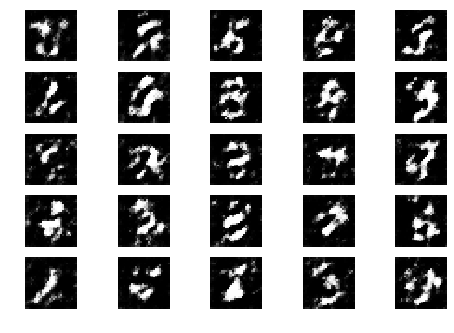

151 [D loss: 0.885251, acc.: 53.12%] [G loss: 1.880503]
152 [D loss: 0.945086, acc.: 57.81%] [G loss: 1.515726]
153 [D loss: 0.973164, acc.: 50.00%] [G loss: 1.454559]
154 [D loss: 0.972181, acc.: 45.31%] [G loss: 1.654501]
155 [D loss: 1.332315, acc.: 39.06%] [G loss: 1.547218]
156 [D loss: 0.835993, acc.: 56.25%] [G loss: 1.380451]
157 [D loss: 1.110628, acc.: 45.31%] [G loss: 1.465792]
158 [D loss: 0.950994, acc.: 48.44%] [G loss: 1.439764]
159 [D loss: 0.955001, acc.: 50.00%] [G loss: 1.838282]
160 [D loss: 1.120099, acc.: 50.00%] [G loss: 1.266272]
161 [D loss: 1.088697, acc.: 39.06%] [G loss: 1.131849]
162 [D loss: 0.861065, acc.: 59.38%] [G loss: 1.517166]
163 [D loss: 0.895821, acc.: 56.25%] [G loss: 1.265154]
164 [D loss: 1.069420, acc.: 45.31%] [G loss: 1.193396]
165 [D loss: 0.737797, acc.: 59.38%] [G loss: 1.936118]
166 [D loss: 0.997033, acc.: 42.19%] [G loss: 1.557471]
167 [D loss: 0.947862, acc.: 48.44%] [G loss: 1.263319]
168 [D loss: 0.844787, acc.: 51.56%] [G loss: 1.

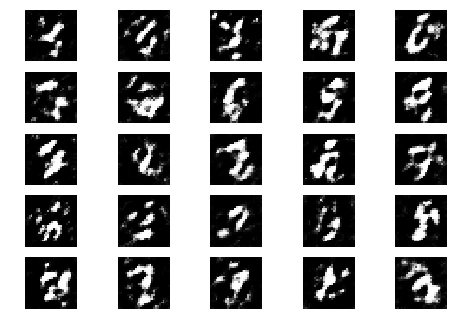

201 [D loss: 1.125390, acc.: 46.88%] [G loss: 1.440895]
202 [D loss: 1.182783, acc.: 45.31%] [G loss: 1.595170]
203 [D loss: 1.206246, acc.: 34.38%] [G loss: 1.547650]
204 [D loss: 0.837651, acc.: 53.12%] [G loss: 1.575550]
205 [D loss: 0.844699, acc.: 56.25%] [G loss: 1.797912]
206 [D loss: 0.801915, acc.: 50.00%] [G loss: 1.109165]
207 [D loss: 1.156703, acc.: 37.50%] [G loss: 1.205256]
208 [D loss: 0.937563, acc.: 48.44%] [G loss: 1.423190]
209 [D loss: 1.081253, acc.: 45.31%] [G loss: 1.262372]
210 [D loss: 0.980765, acc.: 46.88%] [G loss: 1.063812]
211 [D loss: 0.979239, acc.: 51.56%] [G loss: 1.427868]
212 [D loss: 0.992634, acc.: 35.94%] [G loss: 1.652096]
213 [D loss: 0.993832, acc.: 46.88%] [G loss: 1.579726]
214 [D loss: 0.833566, acc.: 57.81%] [G loss: 1.108353]
215 [D loss: 0.940245, acc.: 53.12%] [G loss: 1.581803]
216 [D loss: 0.930975, acc.: 46.88%] [G loss: 1.152800]
217 [D loss: 0.773030, acc.: 59.38%] [G loss: 1.208232]
218 [D loss: 0.998776, acc.: 48.44%] [G loss: 1.

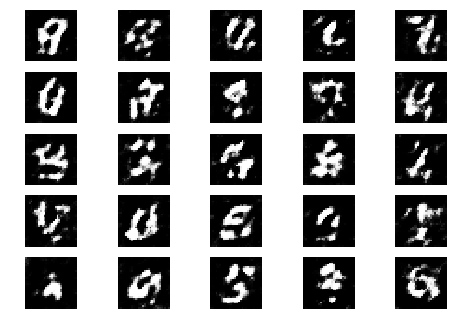

251 [D loss: 0.906033, acc.: 46.88%] [G loss: 1.122232]
252 [D loss: 0.963686, acc.: 46.88%] [G loss: 1.379513]
253 [D loss: 0.832563, acc.: 50.00%] [G loss: 1.376045]
254 [D loss: 0.957664, acc.: 45.31%] [G loss: 1.516474]
255 [D loss: 0.924648, acc.: 39.06%] [G loss: 1.368104]
256 [D loss: 1.132238, acc.: 43.75%] [G loss: 1.028394]
257 [D loss: 1.053129, acc.: 42.19%] [G loss: 1.366612]
258 [D loss: 0.766931, acc.: 60.94%] [G loss: 1.398359]
259 [D loss: 0.977181, acc.: 48.44%] [G loss: 1.221724]
260 [D loss: 0.831677, acc.: 56.25%] [G loss: 1.705824]
261 [D loss: 0.846147, acc.: 48.44%] [G loss: 1.251456]
262 [D loss: 1.035358, acc.: 43.75%] [G loss: 1.106697]
263 [D loss: 0.842069, acc.: 48.44%] [G loss: 1.360099]
264 [D loss: 1.018639, acc.: 50.00%] [G loss: 1.146077]
265 [D loss: 0.884172, acc.: 50.00%] [G loss: 1.153874]
266 [D loss: 1.030025, acc.: 37.50%] [G loss: 1.197140]
267 [D loss: 1.172232, acc.: 40.62%] [G loss: 1.475530]
268 [D loss: 0.965597, acc.: 51.56%] [G loss: 1.

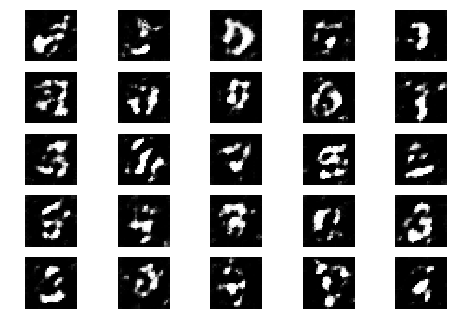

301 [D loss: 0.817036, acc.: 50.00%] [G loss: 1.472716]
302 [D loss: 0.978931, acc.: 34.38%] [G loss: 1.093397]
303 [D loss: 0.965408, acc.: 43.75%] [G loss: 1.154509]
304 [D loss: 0.822700, acc.: 53.12%] [G loss: 1.182830]
305 [D loss: 0.910955, acc.: 43.75%] [G loss: 1.127113]
306 [D loss: 0.887942, acc.: 51.56%] [G loss: 1.371238]
307 [D loss: 0.956390, acc.: 31.25%] [G loss: 1.376950]
308 [D loss: 0.825829, acc.: 50.00%] [G loss: 1.112023]
309 [D loss: 0.880744, acc.: 42.19%] [G loss: 1.374223]
310 [D loss: 0.946682, acc.: 43.75%] [G loss: 1.376745]
311 [D loss: 0.727241, acc.: 67.19%] [G loss: 1.438570]
312 [D loss: 1.188732, acc.: 28.12%] [G loss: 1.359384]
313 [D loss: 0.909884, acc.: 42.19%] [G loss: 1.088819]
314 [D loss: 0.893862, acc.: 48.44%] [G loss: 1.441140]
315 [D loss: 0.919545, acc.: 50.00%] [G loss: 1.237105]
316 [D loss: 1.009288, acc.: 37.50%] [G loss: 1.165678]
317 [D loss: 0.974450, acc.: 42.19%] [G loss: 1.397491]
318 [D loss: 0.971599, acc.: 40.62%] [G loss: 1.

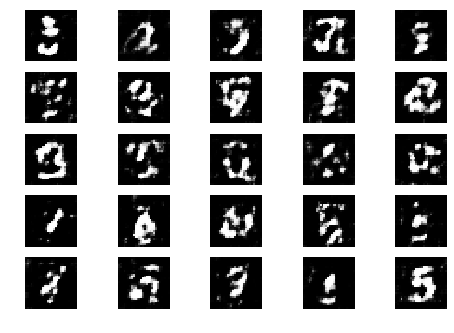

351 [D loss: 0.782994, acc.: 56.25%] [G loss: 1.170819]
352 [D loss: 0.786564, acc.: 50.00%] [G loss: 1.166137]
353 [D loss: 1.024360, acc.: 37.50%] [G loss: 1.081100]
354 [D loss: 0.939237, acc.: 48.44%] [G loss: 1.272214]
355 [D loss: 0.637949, acc.: 73.44%] [G loss: 1.193771]
356 [D loss: 0.939628, acc.: 50.00%] [G loss: 1.146366]
357 [D loss: 0.868925, acc.: 48.44%] [G loss: 0.868114]
358 [D loss: 0.790779, acc.: 53.12%] [G loss: 1.440926]
359 [D loss: 0.824997, acc.: 48.44%] [G loss: 1.204081]
360 [D loss: 1.009916, acc.: 40.62%] [G loss: 0.964386]
361 [D loss: 0.902927, acc.: 43.75%] [G loss: 0.992541]
362 [D loss: 0.885744, acc.: 45.31%] [G loss: 1.180933]
363 [D loss: 0.873065, acc.: 56.25%] [G loss: 1.220778]
364 [D loss: 0.936440, acc.: 40.62%] [G loss: 1.001621]
365 [D loss: 0.920941, acc.: 43.75%] [G loss: 1.288764]
366 [D loss: 0.968156, acc.: 40.62%] [G loss: 1.081124]
367 [D loss: 0.795296, acc.: 54.69%] [G loss: 1.456089]
368 [D loss: 0.981218, acc.: 37.50%] [G loss: 1.

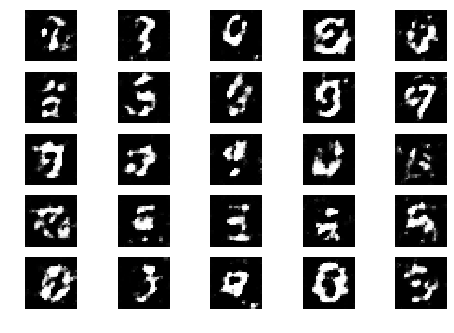

401 [D loss: 1.008589, acc.: 40.62%] [G loss: 1.159029]
402 [D loss: 0.862983, acc.: 51.56%] [G loss: 0.981172]
403 [D loss: 0.969892, acc.: 43.75%] [G loss: 1.190870]
404 [D loss: 0.756407, acc.: 50.00%] [G loss: 1.079723]
405 [D loss: 0.827444, acc.: 45.31%] [G loss: 1.109747]
406 [D loss: 0.827736, acc.: 43.75%] [G loss: 0.958192]
407 [D loss: 0.744051, acc.: 56.25%] [G loss: 1.056169]
408 [D loss: 0.670957, acc.: 60.94%] [G loss: 1.090953]
409 [D loss: 0.662766, acc.: 64.06%] [G loss: 1.120138]
410 [D loss: 0.808147, acc.: 48.44%] [G loss: 1.253736]
411 [D loss: 0.843575, acc.: 46.88%] [G loss: 1.118575]
412 [D loss: 0.823255, acc.: 51.56%] [G loss: 1.324555]
413 [D loss: 0.659627, acc.: 60.94%] [G loss: 1.018445]
414 [D loss: 0.909470, acc.: 48.44%] [G loss: 1.270596]
415 [D loss: 0.832459, acc.: 53.12%] [G loss: 1.217640]
416 [D loss: 0.949161, acc.: 42.19%] [G loss: 1.320980]
417 [D loss: 0.918696, acc.: 39.06%] [G loss: 1.128378]
418 [D loss: 0.857184, acc.: 56.25%] [G loss: 0.

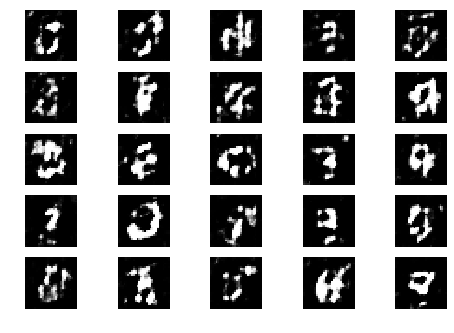

451 [D loss: 0.877861, acc.: 45.31%] [G loss: 1.217895]
452 [D loss: 0.714913, acc.: 60.94%] [G loss: 1.208267]
453 [D loss: 0.848711, acc.: 43.75%] [G loss: 1.014071]
454 [D loss: 0.918568, acc.: 45.31%] [G loss: 1.015006]
455 [D loss: 0.906168, acc.: 37.50%] [G loss: 1.375339]
456 [D loss: 0.742599, acc.: 56.25%] [G loss: 1.160592]
457 [D loss: 0.796693, acc.: 50.00%] [G loss: 1.224983]
458 [D loss: 0.802977, acc.: 45.31%] [G loss: 1.081349]
459 [D loss: 0.948150, acc.: 40.62%] [G loss: 1.008732]
460 [D loss: 0.855698, acc.: 50.00%] [G loss: 1.041198]
461 [D loss: 0.833485, acc.: 53.12%] [G loss: 1.205956]
462 [D loss: 0.689060, acc.: 60.94%] [G loss: 1.136831]
463 [D loss: 0.812568, acc.: 48.44%] [G loss: 1.160859]
464 [D loss: 0.777822, acc.: 53.12%] [G loss: 1.231060]
465 [D loss: 0.899137, acc.: 45.31%] [G loss: 1.105084]
466 [D loss: 0.841076, acc.: 45.31%] [G loss: 1.177739]
467 [D loss: 0.894027, acc.: 40.62%] [G loss: 1.252489]
468 [D loss: 0.743161, acc.: 51.56%] [G loss: 1.

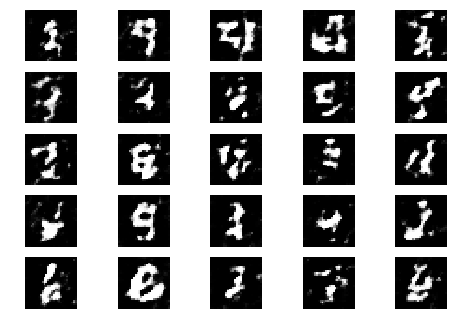

501 [D loss: 0.735250, acc.: 57.81%] [G loss: 1.243015]
502 [D loss: 0.872852, acc.: 48.44%] [G loss: 1.377700]
503 [D loss: 0.814983, acc.: 48.44%] [G loss: 1.233326]
504 [D loss: 0.684628, acc.: 59.38%] [G loss: 1.097459]
505 [D loss: 0.865820, acc.: 46.88%] [G loss: 1.325747]
506 [D loss: 0.781023, acc.: 48.44%] [G loss: 1.214634]
507 [D loss: 0.941967, acc.: 39.06%] [G loss: 1.334797]
508 [D loss: 0.808159, acc.: 54.69%] [G loss: 1.251749]
509 [D loss: 0.822031, acc.: 53.12%] [G loss: 1.197375]
510 [D loss: 0.798571, acc.: 50.00%] [G loss: 1.128543]
511 [D loss: 0.822188, acc.: 51.56%] [G loss: 1.200402]
512 [D loss: 0.737362, acc.: 57.81%] [G loss: 1.096018]
513 [D loss: 0.856076, acc.: 50.00%] [G loss: 1.087255]
514 [D loss: 0.667659, acc.: 60.94%] [G loss: 1.142029]
515 [D loss: 0.848541, acc.: 46.88%] [G loss: 1.066476]
516 [D loss: 0.805410, acc.: 53.12%] [G loss: 1.119099]
517 [D loss: 0.662076, acc.: 60.94%] [G loss: 1.243057]
518 [D loss: 0.750314, acc.: 46.88%] [G loss: 1.

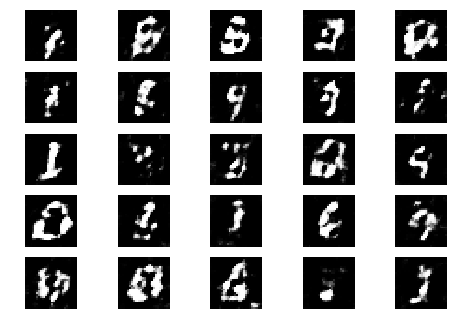

551 [D loss: 0.883438, acc.: 45.31%] [G loss: 1.275385]
552 [D loss: 0.673027, acc.: 57.81%] [G loss: 1.254437]
553 [D loss: 0.838012, acc.: 50.00%] [G loss: 1.245658]
554 [D loss: 0.956191, acc.: 35.94%] [G loss: 1.029265]
555 [D loss: 0.757274, acc.: 53.12%] [G loss: 1.243187]
556 [D loss: 0.809002, acc.: 51.56%] [G loss: 0.916627]
557 [D loss: 0.777811, acc.: 54.69%] [G loss: 1.139798]
558 [D loss: 0.604955, acc.: 64.06%] [G loss: 1.171836]
559 [D loss: 0.666419, acc.: 59.38%] [G loss: 1.118244]
560 [D loss: 0.666483, acc.: 60.94%] [G loss: 1.261030]
561 [D loss: 0.626104, acc.: 60.94%] [G loss: 1.389750]
562 [D loss: 0.732195, acc.: 53.12%] [G loss: 1.328915]
563 [D loss: 0.681903, acc.: 62.50%] [G loss: 0.992571]
564 [D loss: 0.819932, acc.: 45.31%] [G loss: 1.054640]
565 [D loss: 0.818728, acc.: 45.31%] [G loss: 1.151643]
566 [D loss: 0.736652, acc.: 62.50%] [G loss: 1.117871]
567 [D loss: 0.943900, acc.: 37.50%] [G loss: 1.251280]
568 [D loss: 0.814853, acc.: 53.12%] [G loss: 1.

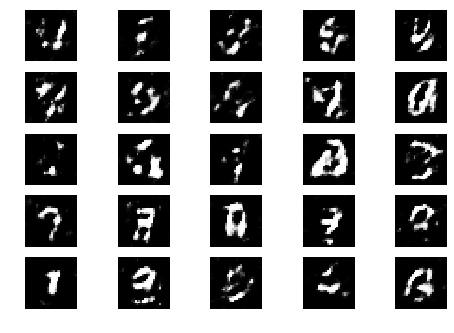

601 [D loss: 0.786624, acc.: 54.69%] [G loss: 1.152874]
602 [D loss: 0.641116, acc.: 64.06%] [G loss: 1.094856]
603 [D loss: 0.727085, acc.: 54.69%] [G loss: 1.044261]
604 [D loss: 0.796014, acc.: 56.25%] [G loss: 1.107016]
605 [D loss: 0.770138, acc.: 57.81%] [G loss: 0.995651]
606 [D loss: 0.721512, acc.: 59.38%] [G loss: 1.328507]
607 [D loss: 0.793986, acc.: 46.88%] [G loss: 1.413705]
608 [D loss: 0.714137, acc.: 60.94%] [G loss: 1.429404]
609 [D loss: 0.707185, acc.: 59.38%] [G loss: 1.555287]
610 [D loss: 0.867986, acc.: 48.44%] [G loss: 1.082138]
611 [D loss: 0.791358, acc.: 46.88%] [G loss: 1.231262]
612 [D loss: 0.822509, acc.: 46.88%] [G loss: 1.473148]
613 [D loss: 0.828903, acc.: 53.12%] [G loss: 1.189152]
614 [D loss: 0.797984, acc.: 54.69%] [G loss: 1.025532]
615 [D loss: 0.866448, acc.: 51.56%] [G loss: 1.021519]
616 [D loss: 0.821708, acc.: 50.00%] [G loss: 1.179654]
617 [D loss: 0.718122, acc.: 60.94%] [G loss: 1.341498]
618 [D loss: 0.729282, acc.: 56.25%] [G loss: 1.

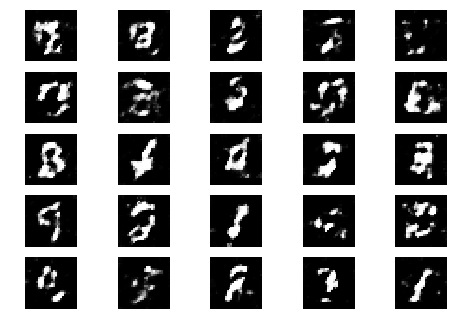

651 [D loss: 0.659051, acc.: 60.94%] [G loss: 1.325600]
652 [D loss: 0.804670, acc.: 50.00%] [G loss: 1.265684]
653 [D loss: 0.714164, acc.: 56.25%] [G loss: 1.129537]
654 [D loss: 0.852092, acc.: 43.75%] [G loss: 1.232737]
655 [D loss: 0.737110, acc.: 62.50%] [G loss: 1.240529]
656 [D loss: 0.652809, acc.: 64.06%] [G loss: 1.327282]
657 [D loss: 0.821942, acc.: 56.25%] [G loss: 1.245413]
658 [D loss: 0.754983, acc.: 51.56%] [G loss: 1.445731]
659 [D loss: 0.712042, acc.: 59.38%] [G loss: 1.184218]
660 [D loss: 0.694047, acc.: 64.06%] [G loss: 1.265224]
661 [D loss: 0.703510, acc.: 53.12%] [G loss: 1.288407]
662 [D loss: 0.751340, acc.: 56.25%] [G loss: 1.239333]
663 [D loss: 0.636050, acc.: 65.62%] [G loss: 1.322087]
664 [D loss: 0.696946, acc.: 59.38%] [G loss: 1.064202]
665 [D loss: 0.921280, acc.: 50.00%] [G loss: 1.314881]
666 [D loss: 0.734300, acc.: 64.06%] [G loss: 1.406026]
667 [D loss: 0.753350, acc.: 54.69%] [G loss: 1.363772]
668 [D loss: 0.834058, acc.: 48.44%] [G loss: 1.

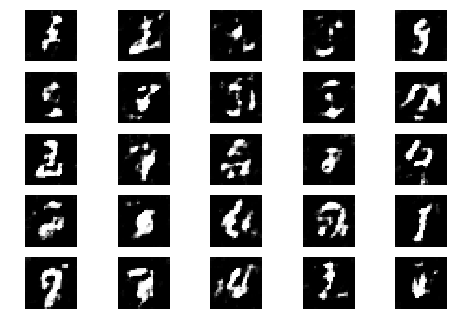

701 [D loss: 0.563834, acc.: 67.19%] [G loss: 1.376909]
702 [D loss: 0.632616, acc.: 62.50%] [G loss: 1.011188]
703 [D loss: 0.832504, acc.: 56.25%] [G loss: 1.338271]
704 [D loss: 0.574431, acc.: 71.88%] [G loss: 1.275095]
705 [D loss: 0.636907, acc.: 65.62%] [G loss: 1.325482]
706 [D loss: 0.702954, acc.: 54.69%] [G loss: 1.344656]
707 [D loss: 0.690073, acc.: 65.62%] [G loss: 1.330389]
708 [D loss: 0.666231, acc.: 60.94%] [G loss: 1.282525]
709 [D loss: 0.829896, acc.: 39.06%] [G loss: 1.181204]
710 [D loss: 0.831577, acc.: 48.44%] [G loss: 1.425444]
711 [D loss: 0.696225, acc.: 56.25%] [G loss: 1.384114]
712 [D loss: 0.585151, acc.: 70.31%] [G loss: 1.356053]
713 [D loss: 0.656551, acc.: 64.06%] [G loss: 1.202221]
714 [D loss: 0.759208, acc.: 53.12%] [G loss: 1.092936]
715 [D loss: 0.667832, acc.: 71.88%] [G loss: 1.085643]
716 [D loss: 0.669203, acc.: 60.94%] [G loss: 1.727172]
717 [D loss: 0.602785, acc.: 76.56%] [G loss: 1.460316]
718 [D loss: 0.725009, acc.: 59.38%] [G loss: 1.

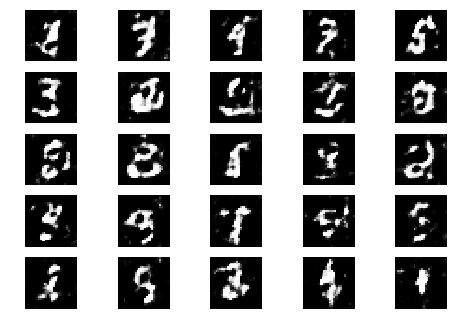

751 [D loss: 0.598723, acc.: 67.19%] [G loss: 1.310876]
752 [D loss: 0.600430, acc.: 68.75%] [G loss: 1.542314]
753 [D loss: 0.765709, acc.: 57.81%] [G loss: 1.204467]
754 [D loss: 0.693669, acc.: 64.06%] [G loss: 1.291045]
755 [D loss: 0.712906, acc.: 59.38%] [G loss: 1.392962]
756 [D loss: 0.598282, acc.: 68.75%] [G loss: 1.251428]
757 [D loss: 0.462097, acc.: 78.12%] [G loss: 1.337088]
758 [D loss: 0.658258, acc.: 60.94%] [G loss: 1.286015]
759 [D loss: 0.646835, acc.: 65.62%] [G loss: 1.519044]
760 [D loss: 0.586362, acc.: 71.88%] [G loss: 1.378033]
761 [D loss: 0.611872, acc.: 60.94%] [G loss: 1.500572]
762 [D loss: 0.537278, acc.: 75.00%] [G loss: 1.255360]
763 [D loss: 0.896287, acc.: 50.00%] [G loss: 1.037701]
764 [D loss: 0.663573, acc.: 60.94%] [G loss: 1.404388]
765 [D loss: 0.515692, acc.: 76.56%] [G loss: 1.367693]
766 [D loss: 0.644384, acc.: 67.19%] [G loss: 1.302899]
767 [D loss: 0.604454, acc.: 67.19%] [G loss: 1.453431]
768 [D loss: 0.634472, acc.: 67.19%] [G loss: 1.

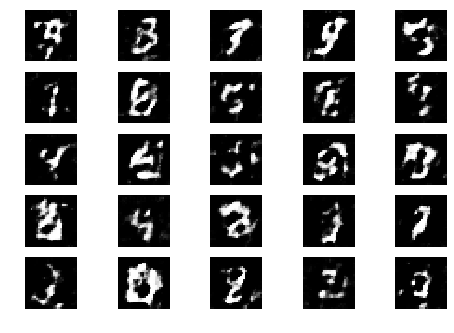

801 [D loss: 0.547094, acc.: 70.31%] [G loss: 1.547723]
802 [D loss: 0.573290, acc.: 68.75%] [G loss: 1.464737]
803 [D loss: 0.569754, acc.: 67.19%] [G loss: 1.406080]
804 [D loss: 0.694908, acc.: 62.50%] [G loss: 1.554219]
805 [D loss: 0.460370, acc.: 84.38%] [G loss: 1.719495]
806 [D loss: 0.626364, acc.: 67.19%] [G loss: 1.598468]
807 [D loss: 0.554795, acc.: 75.00%] [G loss: 1.338671]
808 [D loss: 0.761539, acc.: 51.56%] [G loss: 1.280953]
809 [D loss: 0.531245, acc.: 76.56%] [G loss: 1.503452]
810 [D loss: 0.486350, acc.: 71.88%] [G loss: 1.644858]
811 [D loss: 0.594223, acc.: 71.88%] [G loss: 1.289002]
812 [D loss: 0.637061, acc.: 62.50%] [G loss: 1.357297]
813 [D loss: 0.582427, acc.: 79.69%] [G loss: 1.867946]
814 [D loss: 0.634774, acc.: 64.06%] [G loss: 1.583453]
815 [D loss: 0.507317, acc.: 78.12%] [G loss: 1.395438]
816 [D loss: 0.619057, acc.: 65.62%] [G loss: 1.236615]
817 [D loss: 0.607924, acc.: 64.06%] [G loss: 1.405592]
818 [D loss: 0.585429, acc.: 70.31%] [G loss: 1.

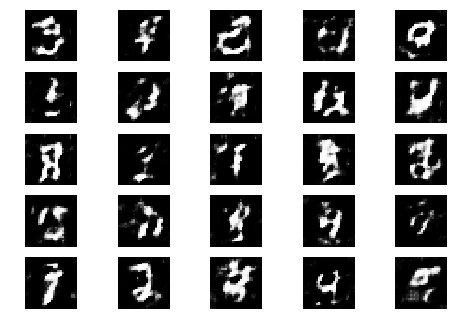

851 [D loss: 0.627316, acc.: 65.62%] [G loss: 1.303187]
852 [D loss: 0.733789, acc.: 60.94%] [G loss: 1.298952]
853 [D loss: 0.499533, acc.: 79.69%] [G loss: 1.520984]
854 [D loss: 0.513311, acc.: 78.12%] [G loss: 1.420014]
855 [D loss: 0.654087, acc.: 57.81%] [G loss: 0.923331]
856 [D loss: 0.615161, acc.: 68.75%] [G loss: 1.429008]
857 [D loss: 0.583220, acc.: 73.44%] [G loss: 1.655160]
858 [D loss: 0.732344, acc.: 59.38%] [G loss: 1.509392]
859 [D loss: 0.541868, acc.: 78.12%] [G loss: 1.454885]
860 [D loss: 0.696104, acc.: 64.06%] [G loss: 1.382889]
861 [D loss: 0.552396, acc.: 71.88%] [G loss: 1.492004]
862 [D loss: 0.408666, acc.: 82.81%] [G loss: 1.914697]
863 [D loss: 0.659408, acc.: 64.06%] [G loss: 1.372491]
864 [D loss: 0.594065, acc.: 64.06%] [G loss: 1.743504]
865 [D loss: 0.818028, acc.: 45.31%] [G loss: 1.313550]
866 [D loss: 0.787005, acc.: 56.25%] [G loss: 1.344790]
867 [D loss: 0.636888, acc.: 71.88%] [G loss: 1.644739]
868 [D loss: 0.543067, acc.: 65.62%] [G loss: 1.

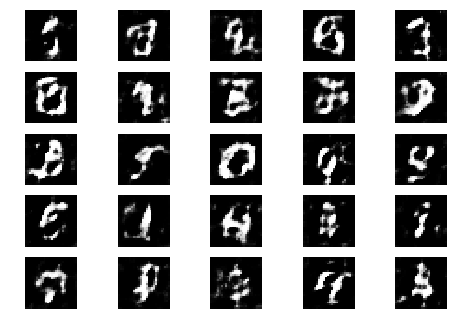

901 [D loss: 0.839847, acc.: 54.69%] [G loss: 1.364270]
902 [D loss: 0.644215, acc.: 60.94%] [G loss: 1.558891]
903 [D loss: 0.582971, acc.: 67.19%] [G loss: 1.765850]
904 [D loss: 0.718531, acc.: 57.81%] [G loss: 1.385002]
905 [D loss: 0.659744, acc.: 53.12%] [G loss: 1.445139]
906 [D loss: 0.655877, acc.: 73.44%] [G loss: 1.663175]
907 [D loss: 0.692454, acc.: 65.62%] [G loss: 1.336628]
908 [D loss: 0.553243, acc.: 67.19%] [G loss: 1.781436]
909 [D loss: 0.758062, acc.: 57.81%] [G loss: 1.225443]
910 [D loss: 0.739613, acc.: 57.81%] [G loss: 1.095340]
911 [D loss: 0.560896, acc.: 71.88%] [G loss: 1.517438]
912 [D loss: 0.576074, acc.: 70.31%] [G loss: 1.573254]
913 [D loss: 0.644755, acc.: 56.25%] [G loss: 1.516306]
914 [D loss: 0.689178, acc.: 62.50%] [G loss: 1.187799]
915 [D loss: 0.709604, acc.: 62.50%] [G loss: 1.347711]
916 [D loss: 0.495628, acc.: 78.12%] [G loss: 1.807162]
917 [D loss: 0.624370, acc.: 65.62%] [G loss: 1.249857]
918 [D loss: 0.731779, acc.: 60.94%] [G loss: 1.

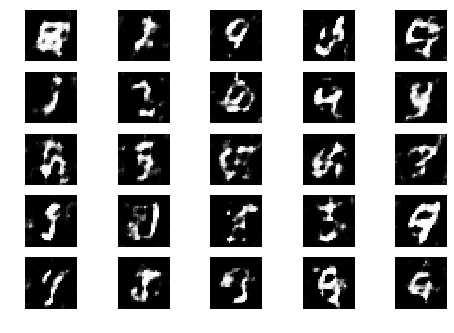

951 [D loss: 0.698686, acc.: 54.69%] [G loss: 1.309623]
952 [D loss: 0.654961, acc.: 59.38%] [G loss: 1.163121]
953 [D loss: 0.687862, acc.: 64.06%] [G loss: 1.668462]
954 [D loss: 0.635096, acc.: 62.50%] [G loss: 1.378927]
955 [D loss: 0.548635, acc.: 64.06%] [G loss: 1.660961]
956 [D loss: 0.575514, acc.: 65.62%] [G loss: 1.909830]
957 [D loss: 0.723821, acc.: 60.94%] [G loss: 1.217258]
958 [D loss: 0.730187, acc.: 56.25%] [G loss: 1.341673]
959 [D loss: 0.694859, acc.: 59.38%] [G loss: 1.354084]
960 [D loss: 0.754527, acc.: 51.56%] [G loss: 1.625844]
961 [D loss: 0.612227, acc.: 64.06%] [G loss: 1.461579]
962 [D loss: 0.749109, acc.: 60.94%] [G loss: 1.434976]
963 [D loss: 0.404695, acc.: 85.94%] [G loss: 1.796573]
964 [D loss: 0.807068, acc.: 42.19%] [G loss: 1.529574]
965 [D loss: 0.511877, acc.: 70.31%] [G loss: 1.453206]
966 [D loss: 0.917755, acc.: 40.62%] [G loss: 1.440664]
967 [D loss: 0.490185, acc.: 75.00%] [G loss: 1.751868]
968 [D loss: 0.650837, acc.: 67.19%] [G loss: 1.

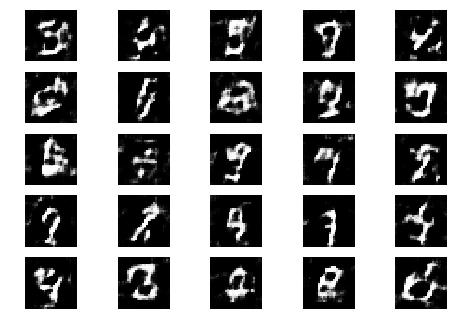

1001 [D loss: 0.619629, acc.: 68.75%] [G loss: 1.468113]
1002 [D loss: 0.662628, acc.: 64.06%] [G loss: 1.217953]
1003 [D loss: 0.603641, acc.: 65.62%] [G loss: 1.775619]
1004 [D loss: 0.978084, acc.: 40.62%] [G loss: 1.217596]
1005 [D loss: 0.581355, acc.: 73.44%] [G loss: 1.297890]
1006 [D loss: 0.847884, acc.: 46.88%] [G loss: 1.100114]
1007 [D loss: 0.758370, acc.: 57.81%] [G loss: 1.186011]
1008 [D loss: 0.687809, acc.: 57.81%] [G loss: 1.379489]
1009 [D loss: 0.773826, acc.: 59.38%] [G loss: 0.981996]
1010 [D loss: 0.654195, acc.: 60.94%] [G loss: 1.668199]
1011 [D loss: 0.952789, acc.: 43.75%] [G loss: 1.450123]
1012 [D loss: 0.568748, acc.: 70.31%] [G loss: 1.553223]
1013 [D loss: 0.623811, acc.: 71.88%] [G loss: 1.172435]
1014 [D loss: 0.611104, acc.: 65.62%] [G loss: 1.470809]
1015 [D loss: 0.573588, acc.: 78.12%] [G loss: 1.440279]
1016 [D loss: 0.811875, acc.: 50.00%] [G loss: 1.535238]
1017 [D loss: 0.565146, acc.: 67.19%] [G loss: 1.976490]
1018 [D loss: 0.971723, acc.: 5

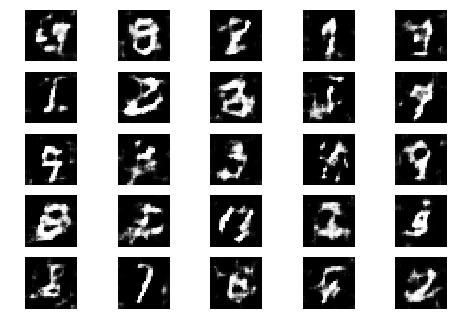

1051 [D loss: 0.700091, acc.: 54.69%] [G loss: 1.431701]
1052 [D loss: 0.578756, acc.: 73.44%] [G loss: 1.437192]
1053 [D loss: 0.585008, acc.: 75.00%] [G loss: 1.376504]
1054 [D loss: 0.652862, acc.: 68.75%] [G loss: 1.554655]
1055 [D loss: 0.529843, acc.: 64.06%] [G loss: 1.594784]
1056 [D loss: 0.688387, acc.: 60.94%] [G loss: 1.407649]
1057 [D loss: 0.723302, acc.: 64.06%] [G loss: 1.357073]
1058 [D loss: 0.730245, acc.: 53.12%] [G loss: 1.668981]
1059 [D loss: 0.751661, acc.: 56.25%] [G loss: 1.390276]
1060 [D loss: 0.640585, acc.: 60.94%] [G loss: 1.470837]
1061 [D loss: 0.951383, acc.: 37.50%] [G loss: 1.034408]
1062 [D loss: 0.766282, acc.: 57.81%] [G loss: 1.304054]
1063 [D loss: 0.674492, acc.: 67.19%] [G loss: 1.451946]
1064 [D loss: 0.880488, acc.: 45.31%] [G loss: 1.336540]
1065 [D loss: 0.623808, acc.: 60.94%] [G loss: 1.858621]
1066 [D loss: 0.651523, acc.: 70.31%] [G loss: 1.439120]
1067 [D loss: 0.566370, acc.: 68.75%] [G loss: 1.385892]
1068 [D loss: 0.750792, acc.: 6

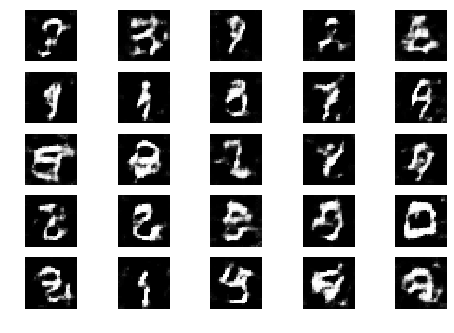

1101 [D loss: 0.717244, acc.: 50.00%] [G loss: 1.401425]
1102 [D loss: 0.724672, acc.: 64.06%] [G loss: 1.309072]
1103 [D loss: 0.677184, acc.: 64.06%] [G loss: 1.505316]
1104 [D loss: 0.641273, acc.: 64.06%] [G loss: 1.362981]
1105 [D loss: 0.650126, acc.: 59.38%] [G loss: 1.310269]
1106 [D loss: 0.633091, acc.: 67.19%] [G loss: 1.438138]
1107 [D loss: 0.722869, acc.: 56.25%] [G loss: 1.588935]
1108 [D loss: 0.609079, acc.: 68.75%] [G loss: 1.331239]
1109 [D loss: 0.822533, acc.: 45.31%] [G loss: 1.237844]
1110 [D loss: 0.711862, acc.: 57.81%] [G loss: 1.134287]
1111 [D loss: 0.696666, acc.: 57.81%] [G loss: 1.215086]
1112 [D loss: 0.725191, acc.: 57.81%] [G loss: 1.255363]
1113 [D loss: 0.689609, acc.: 62.50%] [G loss: 1.369059]
1114 [D loss: 0.729764, acc.: 53.12%] [G loss: 1.419592]
1115 [D loss: 0.854051, acc.: 48.44%] [G loss: 1.378068]
1116 [D loss: 0.581939, acc.: 67.19%] [G loss: 1.317318]
1117 [D loss: 0.694616, acc.: 57.81%] [G loss: 1.220786]
1118 [D loss: 0.585673, acc.: 7

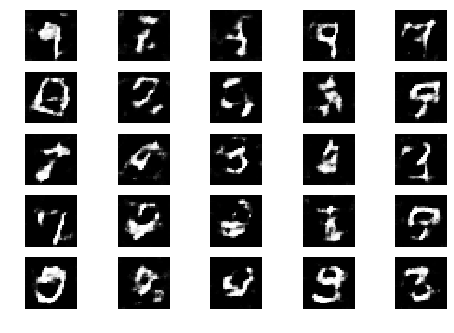

1151 [D loss: 0.634655, acc.: 57.81%] [G loss: 1.506657]
1152 [D loss: 0.657931, acc.: 64.06%] [G loss: 1.297541]
1153 [D loss: 0.870935, acc.: 56.25%] [G loss: 1.224993]
1154 [D loss: 0.731483, acc.: 54.69%] [G loss: 1.295661]
1155 [D loss: 0.649900, acc.: 62.50%] [G loss: 1.301363]
1156 [D loss: 0.715336, acc.: 68.75%] [G loss: 0.950803]
1157 [D loss: 0.610701, acc.: 67.19%] [G loss: 1.114698]
1158 [D loss: 0.850102, acc.: 45.31%] [G loss: 1.329340]
1159 [D loss: 0.602000, acc.: 65.62%] [G loss: 1.662344]
1160 [D loss: 0.600242, acc.: 71.88%] [G loss: 1.243734]
1161 [D loss: 0.672441, acc.: 60.94%] [G loss: 1.284495]
1162 [D loss: 0.686877, acc.: 62.50%] [G loss: 1.656441]
1163 [D loss: 0.637282, acc.: 57.81%] [G loss: 1.448384]
1164 [D loss: 0.735751, acc.: 57.81%] [G loss: 1.054144]
1165 [D loss: 0.656006, acc.: 57.81%] [G loss: 1.557225]
1166 [D loss: 0.689057, acc.: 67.19%] [G loss: 1.753741]
1167 [D loss: 0.781323, acc.: 57.81%] [G loss: 1.436785]
1168 [D loss: 0.659364, acc.: 6

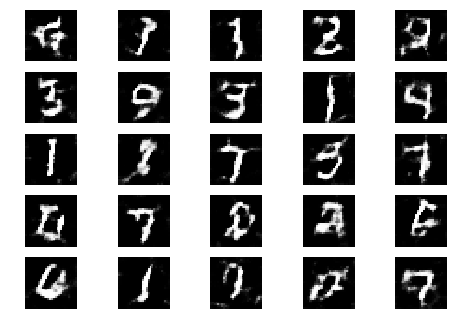

1201 [D loss: 0.697094, acc.: 60.94%] [G loss: 1.473419]
1202 [D loss: 0.598565, acc.: 68.75%] [G loss: 1.421372]
1203 [D loss: 0.720481, acc.: 56.25%] [G loss: 1.356716]
1204 [D loss: 0.715693, acc.: 53.12%] [G loss: 1.559934]
1205 [D loss: 0.654572, acc.: 65.62%] [G loss: 0.947210]
1206 [D loss: 0.473796, acc.: 73.44%] [G loss: 1.580078]
1207 [D loss: 0.756150, acc.: 57.81%] [G loss: 1.160805]
1208 [D loss: 0.697989, acc.: 56.25%] [G loss: 1.339513]
1209 [D loss: 0.783239, acc.: 50.00%] [G loss: 1.586328]
1210 [D loss: 0.584443, acc.: 65.62%] [G loss: 1.189703]
1211 [D loss: 0.710467, acc.: 59.38%] [G loss: 1.511668]
1212 [D loss: 0.676283, acc.: 62.50%] [G loss: 1.248930]
1213 [D loss: 0.591741, acc.: 67.19%] [G loss: 1.583612]
1214 [D loss: 0.651131, acc.: 62.50%] [G loss: 1.448916]
1215 [D loss: 0.606998, acc.: 65.62%] [G loss: 1.405318]
1216 [D loss: 0.721658, acc.: 64.06%] [G loss: 1.384021]
1217 [D loss: 0.660601, acc.: 64.06%] [G loss: 0.964109]
1218 [D loss: 0.608891, acc.: 6

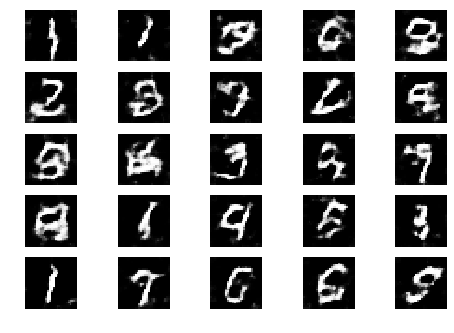

1251 [D loss: 0.645222, acc.: 62.50%] [G loss: 1.309500]
1252 [D loss: 0.584374, acc.: 65.62%] [G loss: 1.490363]
1253 [D loss: 0.584250, acc.: 71.88%] [G loss: 1.392591]
1254 [D loss: 0.875392, acc.: 51.56%] [G loss: 1.564846]
1255 [D loss: 0.835963, acc.: 48.44%] [G loss: 1.250115]
1256 [D loss: 0.752405, acc.: 54.69%] [G loss: 1.614793]
1257 [D loss: 0.793908, acc.: 53.12%] [G loss: 1.108466]
1258 [D loss: 0.640417, acc.: 64.06%] [G loss: 1.126713]
1259 [D loss: 0.641437, acc.: 60.94%] [G loss: 1.331542]
1260 [D loss: 0.882545, acc.: 50.00%] [G loss: 1.130200]
1261 [D loss: 0.690845, acc.: 57.81%] [G loss: 1.271913]
1262 [D loss: 0.634491, acc.: 62.50%] [G loss: 1.557280]
1263 [D loss: 0.718910, acc.: 56.25%] [G loss: 1.503024]
1264 [D loss: 0.570923, acc.: 68.75%] [G loss: 1.318333]
1265 [D loss: 0.608125, acc.: 60.94%] [G loss: 1.396298]
1266 [D loss: 0.754362, acc.: 54.69%] [G loss: 1.516200]
1267 [D loss: 0.718962, acc.: 53.12%] [G loss: 1.310498]
1268 [D loss: 0.742006, acc.: 6

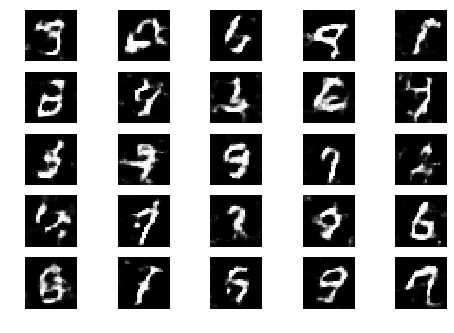

1301 [D loss: 0.669452, acc.: 71.88%] [G loss: 1.435675]
1302 [D loss: 0.772338, acc.: 50.00%] [G loss: 1.192062]
1303 [D loss: 0.604017, acc.: 68.75%] [G loss: 1.309376]
1304 [D loss: 0.728417, acc.: 64.06%] [G loss: 1.197262]
1305 [D loss: 0.540865, acc.: 73.44%] [G loss: 1.171684]
1306 [D loss: 0.614602, acc.: 62.50%] [G loss: 1.175147]
1307 [D loss: 0.833813, acc.: 51.56%] [G loss: 1.144325]
1308 [D loss: 0.573853, acc.: 71.88%] [G loss: 1.422328]
1309 [D loss: 0.697231, acc.: 59.38%] [G loss: 1.215223]
1310 [D loss: 0.728738, acc.: 60.94%] [G loss: 1.259317]
1311 [D loss: 0.780060, acc.: 57.81%] [G loss: 1.163232]
1312 [D loss: 0.684840, acc.: 59.38%] [G loss: 1.376220]
1313 [D loss: 0.687994, acc.: 67.19%] [G loss: 1.525746]
1314 [D loss: 0.848838, acc.: 50.00%] [G loss: 1.428403]
1315 [D loss: 0.471627, acc.: 81.25%] [G loss: 1.429292]
1316 [D loss: 0.647655, acc.: 60.94%] [G loss: 1.360540]
1317 [D loss: 0.715761, acc.: 60.94%] [G loss: 1.207304]
1318 [D loss: 0.758310, acc.: 4

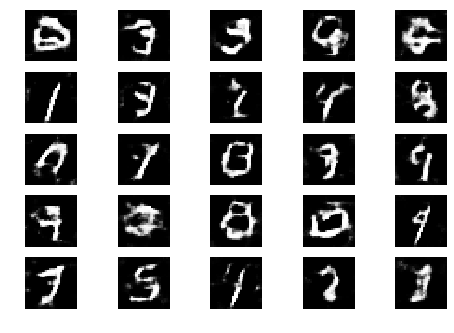

1351 [D loss: 0.700483, acc.: 56.25%] [G loss: 1.293607]
1352 [D loss: 0.710470, acc.: 56.25%] [G loss: 1.322100]
1353 [D loss: 0.699691, acc.: 65.62%] [G loss: 1.398859]
1354 [D loss: 0.611811, acc.: 65.62%] [G loss: 1.647315]
1355 [D loss: 0.642214, acc.: 65.62%] [G loss: 1.404949]
1356 [D loss: 0.644800, acc.: 64.06%] [G loss: 1.353442]
1357 [D loss: 0.616210, acc.: 65.62%] [G loss: 1.237974]
1358 [D loss: 0.634000, acc.: 68.75%] [G loss: 1.306798]
1359 [D loss: 0.576396, acc.: 71.88%] [G loss: 1.462541]
1360 [D loss: 0.565192, acc.: 68.75%] [G loss: 1.488256]
1361 [D loss: 0.669854, acc.: 65.62%] [G loss: 1.341842]
1362 [D loss: 0.734278, acc.: 56.25%] [G loss: 1.229249]
1363 [D loss: 0.703018, acc.: 51.56%] [G loss: 1.210234]
1364 [D loss: 0.765380, acc.: 56.25%] [G loss: 1.207225]
1365 [D loss: 0.754182, acc.: 62.50%] [G loss: 1.237175]
1366 [D loss: 0.721357, acc.: 59.38%] [G loss: 1.344970]
1367 [D loss: 0.723391, acc.: 65.62%] [G loss: 1.263627]
1368 [D loss: 0.493990, acc.: 7

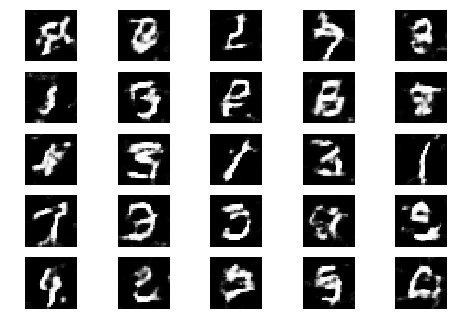

1401 [D loss: 0.722542, acc.: 51.56%] [G loss: 1.236678]
1402 [D loss: 0.672747, acc.: 64.06%] [G loss: 1.255011]
1403 [D loss: 0.512459, acc.: 73.44%] [G loss: 1.290730]
1404 [D loss: 0.654811, acc.: 62.50%] [G loss: 1.299828]
1405 [D loss: 0.725760, acc.: 54.69%] [G loss: 1.323832]
1406 [D loss: 0.639324, acc.: 71.88%] [G loss: 1.154692]
1407 [D loss: 0.626829, acc.: 64.06%] [G loss: 1.111799]
1408 [D loss: 0.672474, acc.: 57.81%] [G loss: 1.175284]
1409 [D loss: 0.799935, acc.: 54.69%] [G loss: 1.211196]
1410 [D loss: 0.668380, acc.: 64.06%] [G loss: 1.268350]
1411 [D loss: 0.610240, acc.: 71.88%] [G loss: 1.284184]
1412 [D loss: 0.722767, acc.: 53.12%] [G loss: 1.333268]
1413 [D loss: 0.788797, acc.: 56.25%] [G loss: 1.444147]
1414 [D loss: 0.737225, acc.: 57.81%] [G loss: 1.401692]
1415 [D loss: 0.642318, acc.: 64.06%] [G loss: 1.255553]
1416 [D loss: 0.712057, acc.: 53.12%] [G loss: 1.342513]
1417 [D loss: 0.517060, acc.: 68.75%] [G loss: 1.585382]
1418 [D loss: 0.685559, acc.: 5

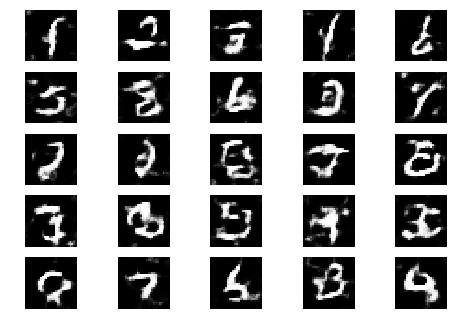

1451 [D loss: 0.783096, acc.: 48.44%] [G loss: 1.171977]
1452 [D loss: 0.748516, acc.: 59.38%] [G loss: 1.242773]
1453 [D loss: 0.637950, acc.: 57.81%] [G loss: 1.200883]
1454 [D loss: 0.684989, acc.: 62.50%] [G loss: 1.076648]
1455 [D loss: 0.788998, acc.: 53.12%] [G loss: 1.117025]
1456 [D loss: 0.784340, acc.: 56.25%] [G loss: 0.738143]
1457 [D loss: 0.721714, acc.: 57.81%] [G loss: 1.133082]
1458 [D loss: 0.563127, acc.: 71.88%] [G loss: 1.487263]
1459 [D loss: 0.653686, acc.: 64.06%] [G loss: 1.194180]
1460 [D loss: 0.610824, acc.: 73.44%] [G loss: 1.283062]
1461 [D loss: 0.802363, acc.: 51.56%] [G loss: 1.406753]
1462 [D loss: 0.587232, acc.: 64.06%] [G loss: 1.418864]
1463 [D loss: 0.618289, acc.: 68.75%] [G loss: 1.451381]
1464 [D loss: 0.629871, acc.: 64.06%] [G loss: 1.464772]
1465 [D loss: 0.671014, acc.: 62.50%] [G loss: 1.605032]
1466 [D loss: 0.658031, acc.: 59.38%] [G loss: 1.133772]
1467 [D loss: 0.854417, acc.: 48.44%] [G loss: 1.070058]
1468 [D loss: 0.556051, acc.: 7

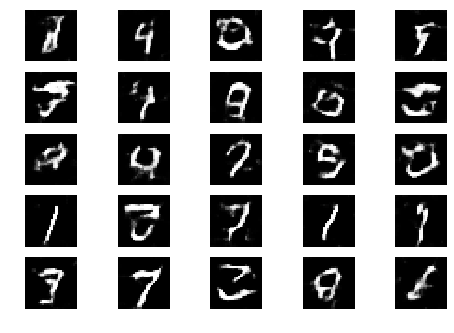

1501 [D loss: 0.695383, acc.: 62.50%] [G loss: 1.401533]
1502 [D loss: 0.691191, acc.: 54.69%] [G loss: 1.453630]
1503 [D loss: 0.625973, acc.: 68.75%] [G loss: 1.693682]
1504 [D loss: 0.600311, acc.: 70.31%] [G loss: 1.213124]
1505 [D loss: 0.594702, acc.: 67.19%] [G loss: 1.173055]
1506 [D loss: 0.675011, acc.: 65.62%] [G loss: 1.432867]
1507 [D loss: 0.653181, acc.: 59.38%] [G loss: 1.274933]
1508 [D loss: 0.604973, acc.: 67.19%] [G loss: 1.340801]
1509 [D loss: 0.636871, acc.: 64.06%] [G loss: 1.488059]
1510 [D loss: 0.611736, acc.: 64.06%] [G loss: 1.656527]
1511 [D loss: 0.725697, acc.: 57.81%] [G loss: 1.347075]
1512 [D loss: 0.910727, acc.: 45.31%] [G loss: 1.365943]
1513 [D loss: 0.890224, acc.: 46.88%] [G loss: 1.232594]
1514 [D loss: 0.597177, acc.: 76.56%] [G loss: 1.449654]
1515 [D loss: 0.645062, acc.: 62.50%] [G loss: 1.495806]
1516 [D loss: 0.585819, acc.: 62.50%] [G loss: 1.464984]
1517 [D loss: 0.710359, acc.: 53.12%] [G loss: 1.178924]
1518 [D loss: 0.487652, acc.: 7

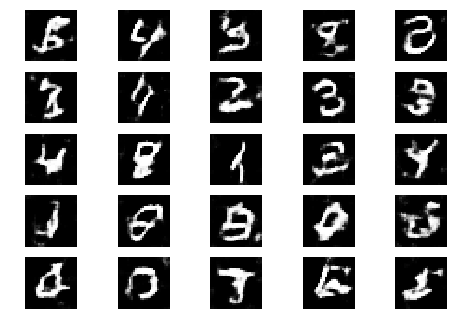

1551 [D loss: 0.601299, acc.: 62.50%] [G loss: 1.503226]
1552 [D loss: 0.606714, acc.: 65.62%] [G loss: 1.453097]
1553 [D loss: 0.663683, acc.: 57.81%] [G loss: 1.206722]
1554 [D loss: 0.713723, acc.: 53.12%] [G loss: 1.365828]
1555 [D loss: 0.638539, acc.: 62.50%] [G loss: 1.113848]
1556 [D loss: 0.599758, acc.: 73.44%] [G loss: 1.364054]
1557 [D loss: 0.647425, acc.: 64.06%] [G loss: 1.338685]
1558 [D loss: 0.702082, acc.: 64.06%] [G loss: 1.073793]
1559 [D loss: 0.531024, acc.: 71.88%] [G loss: 1.225336]
1560 [D loss: 0.578184, acc.: 70.31%] [G loss: 1.384752]
1561 [D loss: 0.747411, acc.: 57.81%] [G loss: 1.027887]
1562 [D loss: 0.603012, acc.: 75.00%] [G loss: 1.303640]
1563 [D loss: 0.697963, acc.: 57.81%] [G loss: 1.254049]
1564 [D loss: 0.668072, acc.: 54.69%] [G loss: 0.993904]
1565 [D loss: 0.649617, acc.: 60.94%] [G loss: 1.348043]
1566 [D loss: 0.677998, acc.: 60.94%] [G loss: 1.462128]
1567 [D loss: 0.653034, acc.: 67.19%] [G loss: 1.349772]
1568 [D loss: 0.596991, acc.: 6

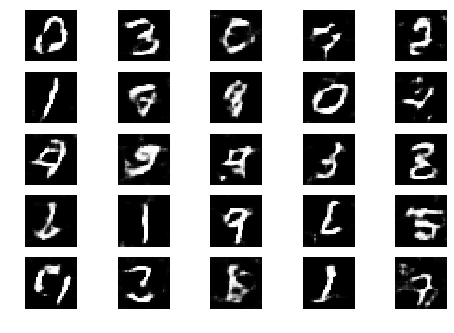

1601 [D loss: 0.699803, acc.: 56.25%] [G loss: 1.203276]
1602 [D loss: 0.675296, acc.: 62.50%] [G loss: 1.208608]
1603 [D loss: 0.529225, acc.: 73.44%] [G loss: 1.331710]
1604 [D loss: 0.628605, acc.: 64.06%] [G loss: 1.457484]
1605 [D loss: 0.687916, acc.: 60.94%] [G loss: 1.331534]
1606 [D loss: 0.662194, acc.: 57.81%] [G loss: 1.080823]
1607 [D loss: 0.556127, acc.: 68.75%] [G loss: 1.603350]
1608 [D loss: 0.700635, acc.: 56.25%] [G loss: 1.479092]
1609 [D loss: 0.644107, acc.: 64.06%] [G loss: 1.564799]
1610 [D loss: 0.750873, acc.: 45.31%] [G loss: 1.398342]
1611 [D loss: 0.704566, acc.: 54.69%] [G loss: 1.231552]
1612 [D loss: 0.744163, acc.: 59.38%] [G loss: 1.378157]
1613 [D loss: 0.740382, acc.: 59.38%] [G loss: 1.304534]
1614 [D loss: 0.618712, acc.: 67.19%] [G loss: 1.537412]
1615 [D loss: 0.645433, acc.: 68.75%] [G loss: 1.170271]
1616 [D loss: 0.511060, acc.: 78.12%] [G loss: 1.374016]
1617 [D loss: 0.645887, acc.: 62.50%] [G loss: 1.116088]
1618 [D loss: 0.641658, acc.: 6

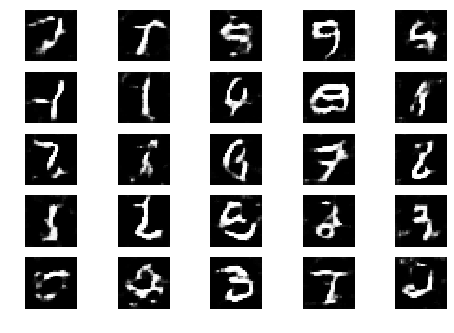

1651 [D loss: 0.619693, acc.: 68.75%] [G loss: 1.263229]
1652 [D loss: 0.631882, acc.: 59.38%] [G loss: 1.233532]
1653 [D loss: 0.548321, acc.: 71.88%] [G loss: 1.608067]
1654 [D loss: 0.658392, acc.: 57.81%] [G loss: 1.432474]
1655 [D loss: 0.637513, acc.: 60.94%] [G loss: 1.525609]
1656 [D loss: 0.616383, acc.: 60.94%] [G loss: 1.137513]
1657 [D loss: 0.751400, acc.: 54.69%] [G loss: 1.599403]
1658 [D loss: 0.669941, acc.: 57.81%] [G loss: 1.674163]
1659 [D loss: 0.631016, acc.: 59.38%] [G loss: 1.376591]
1660 [D loss: 0.897488, acc.: 43.75%] [G loss: 1.251218]
1661 [D loss: 0.598913, acc.: 73.44%] [G loss: 1.473509]
1662 [D loss: 0.529775, acc.: 79.69%] [G loss: 1.805479]
1663 [D loss: 0.772145, acc.: 54.69%] [G loss: 1.337844]
1664 [D loss: 0.782173, acc.: 48.44%] [G loss: 1.083570]
1665 [D loss: 0.636249, acc.: 64.06%] [G loss: 1.265152]
1666 [D loss: 0.744527, acc.: 53.12%] [G loss: 1.235682]
1667 [D loss: 0.681700, acc.: 54.69%] [G loss: 1.164406]
1668 [D loss: 0.712956, acc.: 6

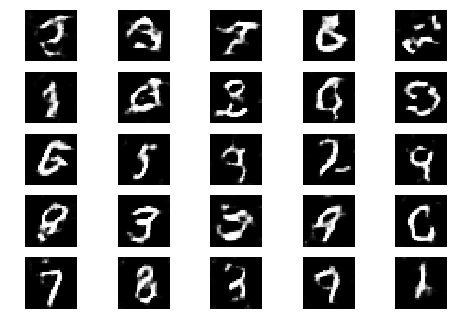

1701 [D loss: 0.680851, acc.: 62.50%] [G loss: 1.460929]
1702 [D loss: 0.508608, acc.: 76.56%] [G loss: 1.347316]
1703 [D loss: 0.741890, acc.: 56.25%] [G loss: 1.409657]
1704 [D loss: 0.549916, acc.: 70.31%] [G loss: 1.260072]
1705 [D loss: 0.658736, acc.: 53.12%] [G loss: 1.067601]
1706 [D loss: 0.559841, acc.: 71.88%] [G loss: 1.816967]
1707 [D loss: 0.671320, acc.: 65.62%] [G loss: 1.518155]
1708 [D loss: 0.826965, acc.: 51.56%] [G loss: 1.221352]
1709 [D loss: 0.614540, acc.: 64.06%] [G loss: 1.325579]
1710 [D loss: 0.726884, acc.: 53.12%] [G loss: 1.284501]
1711 [D loss: 0.700443, acc.: 64.06%] [G loss: 1.427993]
1712 [D loss: 0.597871, acc.: 68.75%] [G loss: 1.256444]
1713 [D loss: 0.511567, acc.: 76.56%] [G loss: 1.592641]
1714 [D loss: 0.700972, acc.: 57.81%] [G loss: 1.257982]
1715 [D loss: 0.634443, acc.: 64.06%] [G loss: 1.259355]
1716 [D loss: 0.576961, acc.: 71.88%] [G loss: 1.286493]
1717 [D loss: 0.683828, acc.: 67.19%] [G loss: 1.249522]
1718 [D loss: 0.587813, acc.: 6

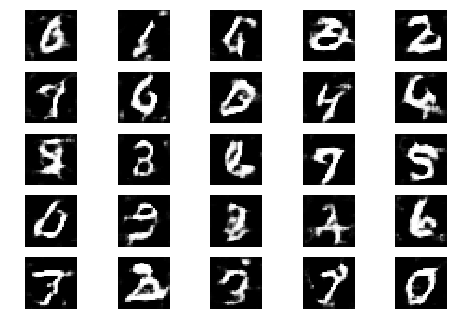

1751 [D loss: 0.663145, acc.: 60.94%] [G loss: 1.758174]
1752 [D loss: 0.776643, acc.: 59.38%] [G loss: 1.026764]
1753 [D loss: 0.674572, acc.: 57.81%] [G loss: 1.273809]
1754 [D loss: 0.737182, acc.: 60.94%] [G loss: 1.500302]
1755 [D loss: 0.580074, acc.: 75.00%] [G loss: 1.157079]
1756 [D loss: 0.548982, acc.: 71.88%] [G loss: 1.271793]
1757 [D loss: 0.723405, acc.: 57.81%] [G loss: 1.287031]
1758 [D loss: 0.677690, acc.: 65.62%] [G loss: 1.732980]
1759 [D loss: 0.716811, acc.: 48.44%] [G loss: 1.239665]
1760 [D loss: 0.832684, acc.: 45.31%] [G loss: 1.099953]
1761 [D loss: 0.702664, acc.: 51.56%] [G loss: 1.263602]
1762 [D loss: 0.706565, acc.: 62.50%] [G loss: 1.307511]
1763 [D loss: 0.531668, acc.: 76.56%] [G loss: 1.527757]
1764 [D loss: 0.584773, acc.: 68.75%] [G loss: 1.285520]
1765 [D loss: 0.549686, acc.: 70.31%] [G loss: 1.349923]
1766 [D loss: 0.557192, acc.: 67.19%] [G loss: 1.373761]
1767 [D loss: 0.572881, acc.: 70.31%] [G loss: 1.190836]
1768 [D loss: 0.567239, acc.: 7

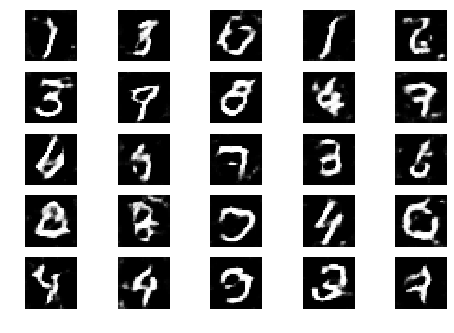

1801 [D loss: 0.504977, acc.: 76.56%] [G loss: 1.158971]
1802 [D loss: 0.601254, acc.: 65.62%] [G loss: 1.207573]
1803 [D loss: 0.794390, acc.: 50.00%] [G loss: 1.019537]
1804 [D loss: 0.609506, acc.: 73.44%] [G loss: 1.381719]
1805 [D loss: 0.500489, acc.: 76.56%] [G loss: 1.503173]
1806 [D loss: 0.590959, acc.: 67.19%] [G loss: 1.383085]
1807 [D loss: 0.668598, acc.: 64.06%] [G loss: 1.395359]
1808 [D loss: 0.736445, acc.: 46.88%] [G loss: 1.430230]
1809 [D loss: 0.949594, acc.: 43.75%] [G loss: 1.165338]
1810 [D loss: 0.694431, acc.: 57.81%] [G loss: 1.409111]
1811 [D loss: 0.667676, acc.: 57.81%] [G loss: 1.487720]
1812 [D loss: 0.579345, acc.: 68.75%] [G loss: 1.211296]
1813 [D loss: 0.509391, acc.: 79.69%] [G loss: 1.399406]
1814 [D loss: 0.913335, acc.: 43.75%] [G loss: 0.923529]
1815 [D loss: 0.575497, acc.: 75.00%] [G loss: 1.217898]
1816 [D loss: 0.593544, acc.: 71.88%] [G loss: 1.580392]
1817 [D loss: 0.679714, acc.: 62.50%] [G loss: 1.288066]
1818 [D loss: 0.650138, acc.: 5

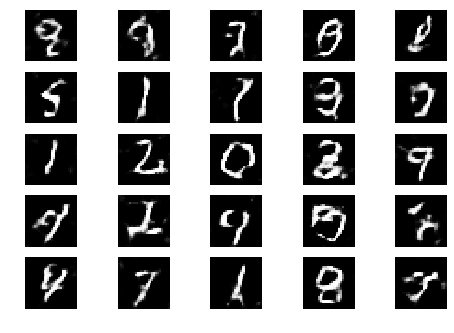

1851 [D loss: 0.480255, acc.: 76.56%] [G loss: 1.334677]
1852 [D loss: 0.696387, acc.: 60.94%] [G loss: 1.289431]
1853 [D loss: 0.713704, acc.: 51.56%] [G loss: 1.313008]
1854 [D loss: 0.635367, acc.: 68.75%] [G loss: 1.329885]
1855 [D loss: 0.672794, acc.: 60.94%] [G loss: 1.380214]
1856 [D loss: 0.864089, acc.: 54.69%] [G loss: 1.116902]
1857 [D loss: 0.497165, acc.: 76.56%] [G loss: 1.268780]
1858 [D loss: 0.566436, acc.: 73.44%] [G loss: 1.394873]
1859 [D loss: 0.610637, acc.: 65.62%] [G loss: 1.418609]
1860 [D loss: 0.628758, acc.: 60.94%] [G loss: 1.319607]
1861 [D loss: 0.805097, acc.: 51.56%] [G loss: 1.278832]
1862 [D loss: 0.692770, acc.: 65.62%] [G loss: 1.261873]
1863 [D loss: 0.630264, acc.: 65.62%] [G loss: 1.667375]
1864 [D loss: 0.558969, acc.: 76.56%] [G loss: 1.690501]
1865 [D loss: 0.576427, acc.: 73.44%] [G loss: 1.422841]
1866 [D loss: 0.633294, acc.: 64.06%] [G loss: 1.482130]
1867 [D loss: 0.544708, acc.: 78.12%] [G loss: 1.311377]
1868 [D loss: 0.635087, acc.: 6

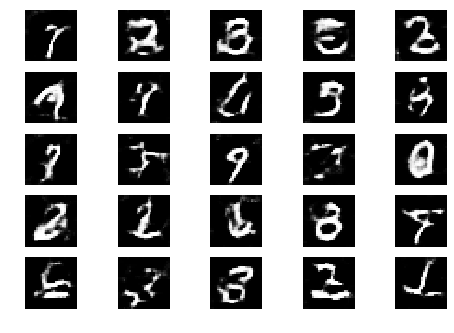

1901 [D loss: 0.530805, acc.: 78.12%] [G loss: 1.514028]
1902 [D loss: 0.562368, acc.: 67.19%] [G loss: 1.470126]
1903 [D loss: 0.684654, acc.: 56.25%] [G loss: 1.412508]
1904 [D loss: 0.702678, acc.: 57.81%] [G loss: 1.238344]
1905 [D loss: 0.583655, acc.: 70.31%] [G loss: 1.401275]
1906 [D loss: 0.577493, acc.: 62.50%] [G loss: 1.022865]
1907 [D loss: 0.544842, acc.: 68.75%] [G loss: 1.034145]
1908 [D loss: 0.776470, acc.: 42.19%] [G loss: 1.449615]
1909 [D loss: 0.657925, acc.: 65.62%] [G loss: 1.381860]
1910 [D loss: 0.661601, acc.: 60.94%] [G loss: 1.476339]
1911 [D loss: 0.586081, acc.: 68.75%] [G loss: 1.407791]
1912 [D loss: 0.559105, acc.: 71.88%] [G loss: 1.669882]
1913 [D loss: 0.671330, acc.: 64.06%] [G loss: 1.438696]
1914 [D loss: 0.469258, acc.: 79.69%] [G loss: 1.405997]
1915 [D loss: 0.583304, acc.: 71.88%] [G loss: 1.351139]
1916 [D loss: 0.519183, acc.: 79.69%] [G loss: 1.501613]
1917 [D loss: 0.596731, acc.: 70.31%] [G loss: 1.630505]
1918 [D loss: 0.619836, acc.: 7

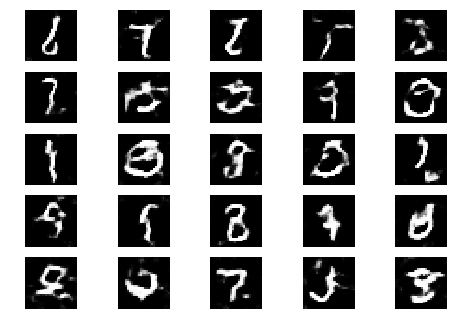

1951 [D loss: 0.697154, acc.: 50.00%] [G loss: 1.501264]
1952 [D loss: 0.640673, acc.: 56.25%] [G loss: 1.253535]
1953 [D loss: 0.730911, acc.: 48.44%] [G loss: 1.035019]
1954 [D loss: 0.635793, acc.: 67.19%] [G loss: 1.477506]
1955 [D loss: 0.624992, acc.: 62.50%] [G loss: 1.270535]
1956 [D loss: 0.635027, acc.: 67.19%] [G loss: 1.370359]
1957 [D loss: 0.556194, acc.: 70.31%] [G loss: 1.355087]
1958 [D loss: 0.581067, acc.: 64.06%] [G loss: 1.183938]
1959 [D loss: 0.543598, acc.: 68.75%] [G loss: 1.551161]
1960 [D loss: 1.008211, acc.: 31.25%] [G loss: 1.351882]
1961 [D loss: 0.628943, acc.: 67.19%] [G loss: 1.435715]
1962 [D loss: 0.712186, acc.: 54.69%] [G loss: 1.270743]
1963 [D loss: 0.596778, acc.: 65.62%] [G loss: 1.364282]
1964 [D loss: 0.611011, acc.: 64.06%] [G loss: 1.343449]
1965 [D loss: 0.735426, acc.: 50.00%] [G loss: 1.356227]
1966 [D loss: 0.622330, acc.: 73.44%] [G loss: 1.245830]
1967 [D loss: 0.700194, acc.: 56.25%] [G loss: 0.989189]
1968 [D loss: 0.667095, acc.: 5

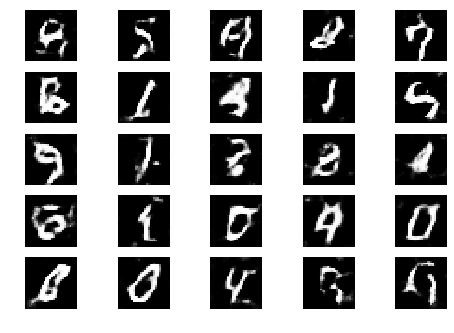

2001 [D loss: 0.578863, acc.: 70.31%] [G loss: 1.295695]
2002 [D loss: 0.649157, acc.: 59.38%] [G loss: 1.553375]
2003 [D loss: 0.636906, acc.: 62.50%] [G loss: 1.386991]
2004 [D loss: 0.693214, acc.: 53.12%] [G loss: 1.588579]
2005 [D loss: 0.622656, acc.: 60.94%] [G loss: 1.165806]
2006 [D loss: 0.765789, acc.: 53.12%] [G loss: 1.002754]
2007 [D loss: 0.729047, acc.: 45.31%] [G loss: 1.591160]
2008 [D loss: 0.579325, acc.: 71.88%] [G loss: 1.702033]
2009 [D loss: 0.664664, acc.: 60.94%] [G loss: 1.465935]
2010 [D loss: 0.640110, acc.: 57.81%] [G loss: 1.722231]
2011 [D loss: 0.626028, acc.: 68.75%] [G loss: 1.307868]
2012 [D loss: 0.596310, acc.: 71.88%] [G loss: 1.522345]
2013 [D loss: 0.818516, acc.: 45.31%] [G loss: 1.259493]
2014 [D loss: 0.701466, acc.: 62.50%] [G loss: 1.673574]
2015 [D loss: 0.537505, acc.: 75.00%] [G loss: 1.501150]
2016 [D loss: 0.584598, acc.: 67.19%] [G loss: 1.486995]
2017 [D loss: 0.672364, acc.: 62.50%] [G loss: 0.956617]
2018 [D loss: 0.711028, acc.: 5

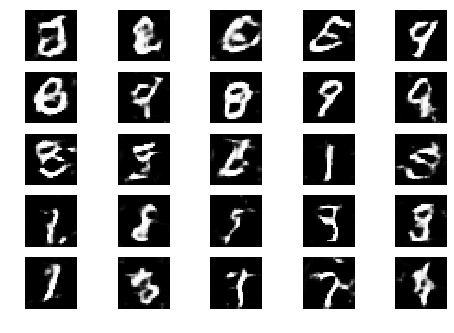

2051 [D loss: 0.698008, acc.: 65.62%] [G loss: 1.189515]
2052 [D loss: 0.705755, acc.: 60.94%] [G loss: 1.385081]
2053 [D loss: 0.581616, acc.: 70.31%] [G loss: 1.359088]
2054 [D loss: 0.577000, acc.: 71.88%] [G loss: 1.584596]
2055 [D loss: 0.810532, acc.: 50.00%] [G loss: 1.391017]
2056 [D loss: 0.827080, acc.: 43.75%] [G loss: 1.221776]
2057 [D loss: 0.759079, acc.: 57.81%] [G loss: 1.472239]
2058 [D loss: 0.582255, acc.: 62.50%] [G loss: 1.435498]
2059 [D loss: 0.688630, acc.: 60.94%] [G loss: 1.383674]
2060 [D loss: 0.624218, acc.: 60.94%] [G loss: 1.029036]
2061 [D loss: 0.783781, acc.: 51.56%] [G loss: 1.358633]
2062 [D loss: 0.545303, acc.: 71.88%] [G loss: 1.297949]
2063 [D loss: 0.808276, acc.: 50.00%] [G loss: 1.424549]
2064 [D loss: 0.618357, acc.: 64.06%] [G loss: 1.247574]
2065 [D loss: 0.733244, acc.: 54.69%] [G loss: 1.381581]
2066 [D loss: 0.609612, acc.: 65.62%] [G loss: 1.034846]
2067 [D loss: 0.864112, acc.: 48.44%] [G loss: 1.089015]
2068 [D loss: 0.618539, acc.: 6

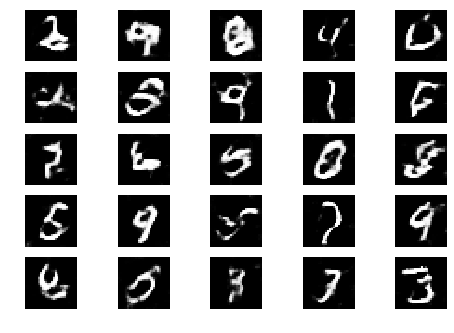

2101 [D loss: 0.671134, acc.: 64.06%] [G loss: 1.465498]
2102 [D loss: 0.637247, acc.: 65.62%] [G loss: 1.499972]
2103 [D loss: 0.709642, acc.: 57.81%] [G loss: 1.421002]
2104 [D loss: 0.741960, acc.: 56.25%] [G loss: 1.351812]
2105 [D loss: 0.635678, acc.: 67.19%] [G loss: 1.175975]
2106 [D loss: 0.658972, acc.: 62.50%] [G loss: 1.086270]
2107 [D loss: 0.688149, acc.: 65.62%] [G loss: 1.375827]
2108 [D loss: 0.644596, acc.: 70.31%] [G loss: 1.443054]
2109 [D loss: 0.548681, acc.: 71.88%] [G loss: 1.910852]
2110 [D loss: 0.612809, acc.: 60.94%] [G loss: 1.566685]
2111 [D loss: 0.708527, acc.: 56.25%] [G loss: 1.192403]
2112 [D loss: 0.542076, acc.: 70.31%] [G loss: 1.060429]
2113 [D loss: 0.787228, acc.: 51.56%] [G loss: 1.280280]
2114 [D loss: 0.658220, acc.: 62.50%] [G loss: 1.520798]
2115 [D loss: 0.675448, acc.: 60.94%] [G loss: 1.496271]
2116 [D loss: 0.744489, acc.: 53.12%] [G loss: 1.248897]
2117 [D loss: 0.674376, acc.: 64.06%] [G loss: 1.399369]
2118 [D loss: 0.667810, acc.: 6

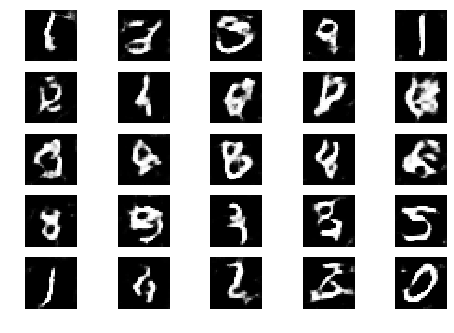

2151 [D loss: 0.668576, acc.: 60.94%] [G loss: 1.180231]
2152 [D loss: 0.569783, acc.: 65.62%] [G loss: 1.138674]
2153 [D loss: 0.528206, acc.: 67.19%] [G loss: 1.354659]
2154 [D loss: 0.558976, acc.: 70.31%] [G loss: 1.367097]
2155 [D loss: 0.554283, acc.: 73.44%] [G loss: 1.247519]
2156 [D loss: 0.493561, acc.: 75.00%] [G loss: 1.398710]
2157 [D loss: 0.674870, acc.: 59.38%] [G loss: 1.407503]
2158 [D loss: 0.693197, acc.: 54.69%] [G loss: 1.345532]
2159 [D loss: 0.663351, acc.: 64.06%] [G loss: 1.273299]
2160 [D loss: 0.484872, acc.: 82.81%] [G loss: 1.303066]
2161 [D loss: 0.533454, acc.: 68.75%] [G loss: 1.259640]
2162 [D loss: 0.728550, acc.: 53.12%] [G loss: 1.200538]
2163 [D loss: 0.459758, acc.: 81.25%] [G loss: 1.550575]
2164 [D loss: 0.646373, acc.: 68.75%] [G loss: 1.200857]
2165 [D loss: 0.573278, acc.: 67.19%] [G loss: 1.120463]
2166 [D loss: 0.568342, acc.: 71.88%] [G loss: 1.328220]
2167 [D loss: 0.711337, acc.: 57.81%] [G loss: 1.295095]
2168 [D loss: 0.668708, acc.: 5

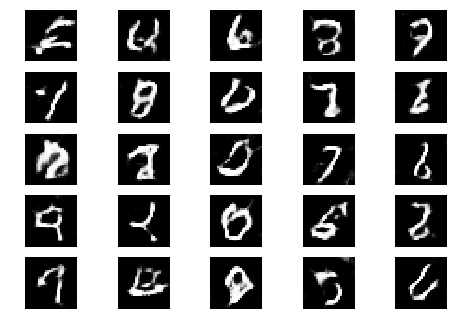

2201 [D loss: 0.507549, acc.: 75.00%] [G loss: 1.527497]
2202 [D loss: 0.561390, acc.: 70.31%] [G loss: 1.062596]
2203 [D loss: 0.621346, acc.: 70.31%] [G loss: 1.459139]
2204 [D loss: 0.491832, acc.: 76.56%] [G loss: 1.472449]
2205 [D loss: 0.539182, acc.: 67.19%] [G loss: 1.591641]
2206 [D loss: 0.707248, acc.: 68.75%] [G loss: 1.219119]
2207 [D loss: 0.796675, acc.: 45.31%] [G loss: 1.256263]
2208 [D loss: 0.610002, acc.: 68.75%] [G loss: 1.567956]
2209 [D loss: 0.601235, acc.: 65.62%] [G loss: 1.493307]
2210 [D loss: 0.626783, acc.: 64.06%] [G loss: 1.406191]
2211 [D loss: 0.615025, acc.: 67.19%] [G loss: 1.398905]
2212 [D loss: 0.642155, acc.: 60.94%] [G loss: 1.861481]
2213 [D loss: 0.710151, acc.: 60.94%] [G loss: 1.208827]
2214 [D loss: 0.571938, acc.: 71.88%] [G loss: 1.215052]
2215 [D loss: 0.613616, acc.: 65.62%] [G loss: 1.174821]
2216 [D loss: 0.497859, acc.: 76.56%] [G loss: 1.639102]
2217 [D loss: 0.574548, acc.: 75.00%] [G loss: 1.234664]
2218 [D loss: 0.595683, acc.: 6

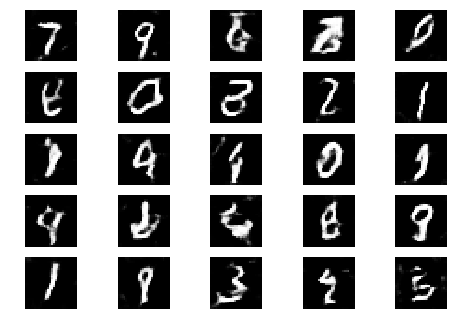

2251 [D loss: 0.637905, acc.: 59.38%] [G loss: 1.221888]
2252 [D loss: 0.582952, acc.: 68.75%] [G loss: 1.612207]
2253 [D loss: 0.717746, acc.: 54.69%] [G loss: 1.475712]
2254 [D loss: 0.546417, acc.: 75.00%] [G loss: 1.542107]
2255 [D loss: 0.551873, acc.: 67.19%] [G loss: 1.172837]
2256 [D loss: 0.552560, acc.: 75.00%] [G loss: 1.146897]
2257 [D loss: 0.504417, acc.: 76.56%] [G loss: 1.192562]
2258 [D loss: 0.555442, acc.: 73.44%] [G loss: 1.484732]
2259 [D loss: 0.603505, acc.: 64.06%] [G loss: 1.359329]
2260 [D loss: 0.615887, acc.: 67.19%] [G loss: 1.258617]
2261 [D loss: 0.685971, acc.: 65.62%] [G loss: 0.952792]
2262 [D loss: 0.552781, acc.: 75.00%] [G loss: 1.291824]
2263 [D loss: 0.679921, acc.: 64.06%] [G loss: 1.432088]
2264 [D loss: 0.685107, acc.: 62.50%] [G loss: 1.508675]
2265 [D loss: 0.438736, acc.: 76.56%] [G loss: 1.517133]
2266 [D loss: 0.576275, acc.: 67.19%] [G loss: 1.346257]
2267 [D loss: 0.848865, acc.: 50.00%] [G loss: 1.213217]
2268 [D loss: 0.683980, acc.: 6

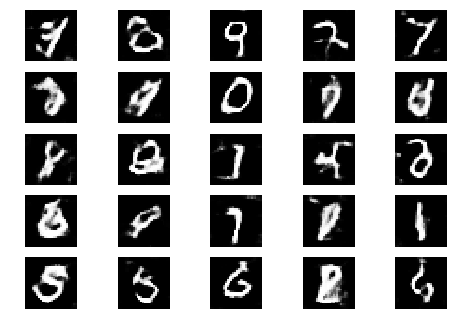

2301 [D loss: 0.725137, acc.: 54.69%] [G loss: 1.294652]
2302 [D loss: 0.673253, acc.: 64.06%] [G loss: 1.250196]
2303 [D loss: 0.805599, acc.: 51.56%] [G loss: 1.276534]
2304 [D loss: 0.598368, acc.: 71.88%] [G loss: 1.234360]
2305 [D loss: 0.666194, acc.: 59.38%] [G loss: 1.597927]
2306 [D loss: 0.562710, acc.: 68.75%] [G loss: 1.625589]
2307 [D loss: 0.488717, acc.: 78.12%] [G loss: 1.650914]
2308 [D loss: 0.685927, acc.: 62.50%] [G loss: 1.749978]
2309 [D loss: 0.613685, acc.: 64.06%] [G loss: 1.357484]
2310 [D loss: 0.615437, acc.: 59.38%] [G loss: 1.573359]
2311 [D loss: 0.617958, acc.: 59.38%] [G loss: 1.017917]
2312 [D loss: 0.682364, acc.: 60.94%] [G loss: 1.146841]
2313 [D loss: 0.774215, acc.: 54.69%] [G loss: 1.308870]
2314 [D loss: 0.572731, acc.: 67.19%] [G loss: 1.735910]
2315 [D loss: 0.525460, acc.: 78.12%] [G loss: 1.451553]
2316 [D loss: 0.704018, acc.: 57.81%] [G loss: 1.161774]
2317 [D loss: 0.665987, acc.: 68.75%] [G loss: 1.211158]
2318 [D loss: 0.693943, acc.: 5

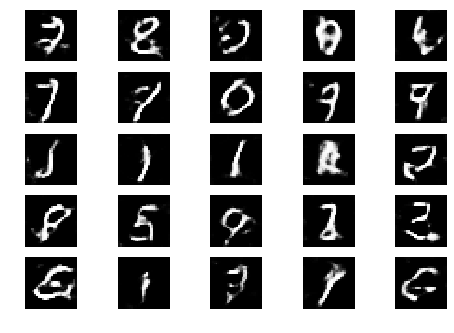

2351 [D loss: 0.602553, acc.: 60.94%] [G loss: 1.230353]
2352 [D loss: 0.522393, acc.: 75.00%] [G loss: 1.517065]
2353 [D loss: 0.685902, acc.: 60.94%] [G loss: 1.135767]
2354 [D loss: 0.434256, acc.: 84.38%] [G loss: 1.250699]
2355 [D loss: 0.639007, acc.: 60.94%] [G loss: 1.142590]
2356 [D loss: 0.624825, acc.: 59.38%] [G loss: 1.353705]
2357 [D loss: 0.506191, acc.: 75.00%] [G loss: 1.742141]
2358 [D loss: 0.539353, acc.: 75.00%] [G loss: 1.501936]
2359 [D loss: 0.688699, acc.: 59.38%] [G loss: 1.420637]
2360 [D loss: 0.703633, acc.: 59.38%] [G loss: 1.231793]
2361 [D loss: 0.555496, acc.: 71.88%] [G loss: 1.976788]
2362 [D loss: 0.636813, acc.: 64.06%] [G loss: 1.471107]
2363 [D loss: 0.627868, acc.: 73.44%] [G loss: 1.352059]
2364 [D loss: 0.629447, acc.: 64.06%] [G loss: 1.570869]
2365 [D loss: 0.664344, acc.: 59.38%] [G loss: 1.351676]
2366 [D loss: 0.653585, acc.: 64.06%] [G loss: 1.478057]
2367 [D loss: 0.543279, acc.: 73.44%] [G loss: 1.214275]
2368 [D loss: 0.440311, acc.: 8

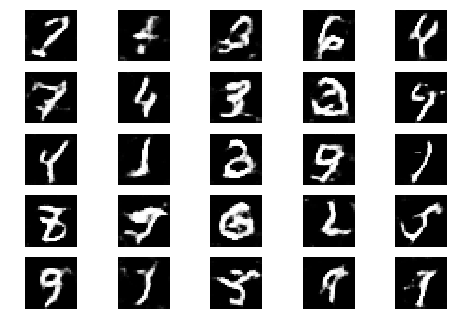

2401 [D loss: 0.538794, acc.: 75.00%] [G loss: 1.205026]
2402 [D loss: 0.635370, acc.: 71.88%] [G loss: 1.452032]
2403 [D loss: 0.580964, acc.: 71.88%] [G loss: 1.401336]
2404 [D loss: 0.761119, acc.: 59.38%] [G loss: 1.498552]
2405 [D loss: 0.561876, acc.: 75.00%] [G loss: 1.250860]
2406 [D loss: 0.800793, acc.: 57.81%] [G loss: 1.164823]
2407 [D loss: 0.832371, acc.: 48.44%] [G loss: 1.206674]
2408 [D loss: 0.581490, acc.: 68.75%] [G loss: 1.489958]
2409 [D loss: 0.537294, acc.: 73.44%] [G loss: 1.249684]
2410 [D loss: 0.582469, acc.: 73.44%] [G loss: 1.382561]
2411 [D loss: 0.751828, acc.: 57.81%] [G loss: 1.366220]
2412 [D loss: 0.564895, acc.: 68.75%] [G loss: 1.570300]
2413 [D loss: 0.528895, acc.: 73.44%] [G loss: 1.520874]
2414 [D loss: 0.687676, acc.: 62.50%] [G loss: 1.223722]
2415 [D loss: 0.479617, acc.: 79.69%] [G loss: 1.593903]
2416 [D loss: 0.607915, acc.: 67.19%] [G loss: 1.312241]
2417 [D loss: 0.535863, acc.: 79.69%] [G loss: 1.352891]
2418 [D loss: 0.484221, acc.: 7

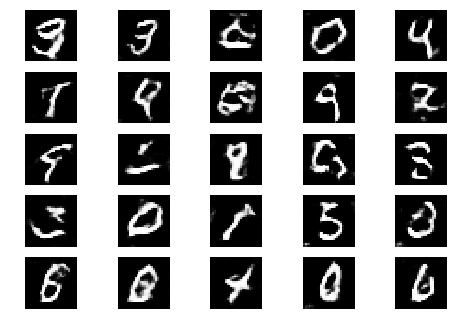

2451 [D loss: 0.670718, acc.: 62.50%] [G loss: 1.416798]
2452 [D loss: 0.577496, acc.: 73.44%] [G loss: 1.481750]
2453 [D loss: 0.682217, acc.: 64.06%] [G loss: 1.294665]
2454 [D loss: 0.666293, acc.: 62.50%] [G loss: 1.120812]
2455 [D loss: 0.624803, acc.: 65.62%] [G loss: 1.307891]
2456 [D loss: 0.642238, acc.: 59.38%] [G loss: 1.748072]
2457 [D loss: 0.589186, acc.: 70.31%] [G loss: 1.683799]
2458 [D loss: 0.733698, acc.: 53.12%] [G loss: 1.407096]
2459 [D loss: 0.764992, acc.: 56.25%] [G loss: 1.394499]
2460 [D loss: 0.590614, acc.: 73.44%] [G loss: 1.534982]
2461 [D loss: 0.446191, acc.: 81.25%] [G loss: 1.612275]
2462 [D loss: 0.510409, acc.: 73.44%] [G loss: 1.233333]
2463 [D loss: 0.719509, acc.: 53.12%] [G loss: 0.856733]
2464 [D loss: 0.439062, acc.: 82.81%] [G loss: 1.347323]
2465 [D loss: 0.737429, acc.: 54.69%] [G loss: 1.699206]
2466 [D loss: 0.547733, acc.: 71.88%] [G loss: 1.320694]
2467 [D loss: 0.683924, acc.: 56.25%] [G loss: 1.154766]
2468 [D loss: 0.749465, acc.: 5

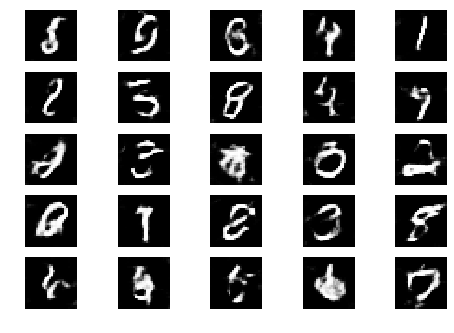

2501 [D loss: 0.585371, acc.: 68.75%] [G loss: 1.487688]
2502 [D loss: 0.648490, acc.: 60.94%] [G loss: 1.032415]
2503 [D loss: 0.519721, acc.: 73.44%] [G loss: 1.231030]
2504 [D loss: 0.722737, acc.: 59.38%] [G loss: 1.050138]
2505 [D loss: 0.550599, acc.: 68.75%] [G loss: 1.346004]
2506 [D loss: 0.694658, acc.: 65.62%] [G loss: 0.985613]
2507 [D loss: 0.444783, acc.: 82.81%] [G loss: 1.366587]
2508 [D loss: 0.705276, acc.: 57.81%] [G loss: 1.401024]
2509 [D loss: 0.616111, acc.: 68.75%] [G loss: 1.268747]
2510 [D loss: 0.571296, acc.: 76.56%] [G loss: 1.337906]
2511 [D loss: 0.542327, acc.: 73.44%] [G loss: 1.592278]
2512 [D loss: 0.521402, acc.: 73.44%] [G loss: 1.503787]
2513 [D loss: 0.466971, acc.: 81.25%] [G loss: 1.330101]
2514 [D loss: 0.591785, acc.: 65.62%] [G loss: 1.623651]
2515 [D loss: 0.866024, acc.: 46.88%] [G loss: 1.232936]
2516 [D loss: 0.706875, acc.: 62.50%] [G loss: 1.405103]
2517 [D loss: 0.615479, acc.: 71.88%] [G loss: 1.216740]
2518 [D loss: 0.547514, acc.: 7

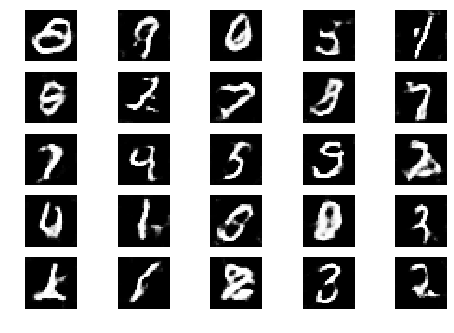

2551 [D loss: 0.599688, acc.: 68.75%] [G loss: 1.734604]
2552 [D loss: 0.537995, acc.: 78.12%] [G loss: 1.447932]
2553 [D loss: 0.680375, acc.: 57.81%] [G loss: 1.287176]
2554 [D loss: 0.735318, acc.: 57.81%] [G loss: 1.586246]
2555 [D loss: 0.519766, acc.: 79.69%] [G loss: 1.506654]
2556 [D loss: 0.689567, acc.: 65.62%] [G loss: 1.069932]
2557 [D loss: 0.692535, acc.: 59.38%] [G loss: 1.286102]
2558 [D loss: 0.700529, acc.: 64.06%] [G loss: 1.252735]
2559 [D loss: 0.553190, acc.: 70.31%] [G loss: 1.142979]
2560 [D loss: 0.604584, acc.: 70.31%] [G loss: 1.335488]
2561 [D loss: 0.621674, acc.: 60.94%] [G loss: 1.199679]
2562 [D loss: 0.621833, acc.: 65.62%] [G loss: 1.137951]
2563 [D loss: 0.439200, acc.: 79.69%] [G loss: 1.495259]
2564 [D loss: 0.736698, acc.: 51.56%] [G loss: 1.334839]
2565 [D loss: 0.705099, acc.: 57.81%] [G loss: 1.054341]
2566 [D loss: 0.563535, acc.: 70.31%] [G loss: 1.505738]
2567 [D loss: 0.705509, acc.: 56.25%] [G loss: 1.456687]
2568 [D loss: 0.539020, acc.: 7

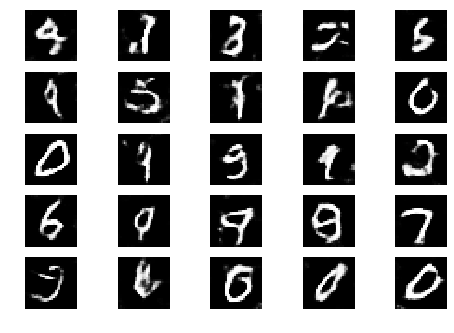

2601 [D loss: 0.700126, acc.: 64.06%] [G loss: 1.119224]
2602 [D loss: 0.611123, acc.: 68.75%] [G loss: 1.351852]
2603 [D loss: 0.736445, acc.: 57.81%] [G loss: 1.312205]
2604 [D loss: 0.481858, acc.: 81.25%] [G loss: 1.507599]
2605 [D loss: 0.600823, acc.: 68.75%] [G loss: 1.233888]
2606 [D loss: 0.498550, acc.: 76.56%] [G loss: 1.301284]
2607 [D loss: 0.617091, acc.: 68.75%] [G loss: 1.212032]
2608 [D loss: 0.617064, acc.: 62.50%] [G loss: 1.401439]
2609 [D loss: 0.488403, acc.: 78.12%] [G loss: 1.567775]
2610 [D loss: 0.543406, acc.: 73.44%] [G loss: 1.427981]
2611 [D loss: 0.595413, acc.: 68.75%] [G loss: 1.175679]
2612 [D loss: 0.492952, acc.: 76.56%] [G loss: 1.531001]
2613 [D loss: 0.849612, acc.: 51.56%] [G loss: 1.431447]
2614 [D loss: 0.675474, acc.: 60.94%] [G loss: 0.989997]
2615 [D loss: 0.596159, acc.: 67.19%] [G loss: 1.197859]
2616 [D loss: 0.517334, acc.: 76.56%] [G loss: 1.665348]
2617 [D loss: 0.779577, acc.: 46.88%] [G loss: 1.243952]
2618 [D loss: 0.610261, acc.: 7

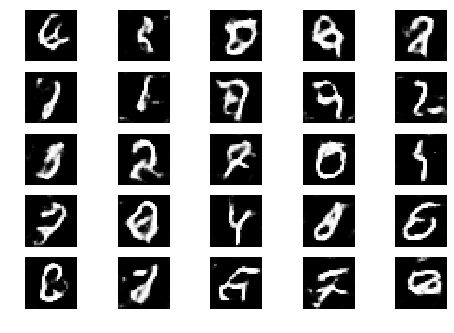

2651 [D loss: 0.484547, acc.: 75.00%] [G loss: 1.582498]
2652 [D loss: 0.444700, acc.: 89.06%] [G loss: 1.585998]
2653 [D loss: 0.609991, acc.: 65.62%] [G loss: 1.409920]
2654 [D loss: 0.672832, acc.: 64.06%] [G loss: 1.254185]
2655 [D loss: 0.731564, acc.: 56.25%] [G loss: 1.282189]
2656 [D loss: 0.645775, acc.: 68.75%] [G loss: 1.305808]
2657 [D loss: 0.629493, acc.: 68.75%] [G loss: 1.609026]
2658 [D loss: 0.505414, acc.: 79.69%] [G loss: 1.320570]
2659 [D loss: 0.605465, acc.: 68.75%] [G loss: 1.181607]
2660 [D loss: 0.597159, acc.: 71.88%] [G loss: 1.354952]
2661 [D loss: 0.709185, acc.: 56.25%] [G loss: 1.293905]
2662 [D loss: 0.698725, acc.: 53.12%] [G loss: 1.082892]
2663 [D loss: 0.675427, acc.: 64.06%] [G loss: 1.341501]
2664 [D loss: 0.812583, acc.: 56.25%] [G loss: 1.110328]
2665 [D loss: 0.495634, acc.: 76.56%] [G loss: 1.621489]
2666 [D loss: 0.741710, acc.: 56.25%] [G loss: 1.563829]
2667 [D loss: 0.546173, acc.: 75.00%] [G loss: 1.275548]
2668 [D loss: 0.612548, acc.: 7

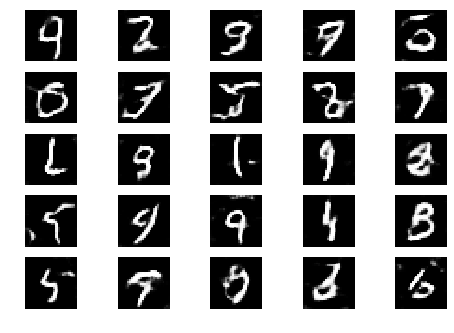

2701 [D loss: 0.744618, acc.: 53.12%] [G loss: 1.449520]
2702 [D loss: 0.675549, acc.: 57.81%] [G loss: 1.657172]
2703 [D loss: 0.751621, acc.: 56.25%] [G loss: 1.160841]
2704 [D loss: 0.632717, acc.: 62.50%] [G loss: 0.952044]
2705 [D loss: 0.408923, acc.: 89.06%] [G loss: 1.413052]
2706 [D loss: 0.596596, acc.: 67.19%] [G loss: 1.101118]
2707 [D loss: 0.611333, acc.: 65.62%] [G loss: 1.442628]
2708 [D loss: 0.599591, acc.: 62.50%] [G loss: 1.116516]
2709 [D loss: 0.568972, acc.: 70.31%] [G loss: 1.460661]
2710 [D loss: 0.628739, acc.: 59.38%] [G loss: 1.405171]
2711 [D loss: 0.683825, acc.: 54.69%] [G loss: 1.373998]
2712 [D loss: 0.723349, acc.: 51.56%] [G loss: 1.210550]
2713 [D loss: 0.611075, acc.: 64.06%] [G loss: 1.422155]
2714 [D loss: 0.582664, acc.: 67.19%] [G loss: 1.122056]
2715 [D loss: 0.509789, acc.: 70.31%] [G loss: 1.457279]
2716 [D loss: 0.581100, acc.: 67.19%] [G loss: 0.963465]
2717 [D loss: 0.627715, acc.: 68.75%] [G loss: 1.339484]
2718 [D loss: 0.536683, acc.: 7

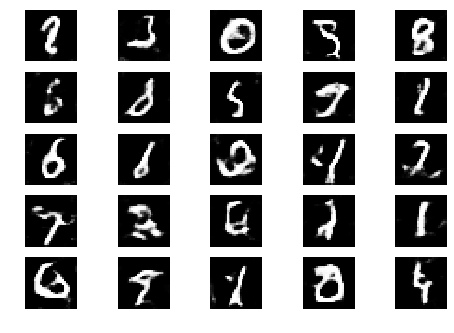

2751 [D loss: 0.572397, acc.: 68.75%] [G loss: 1.580607]
2752 [D loss: 0.768972, acc.: 60.94%] [G loss: 1.442777]
2753 [D loss: 0.699358, acc.: 60.94%] [G loss: 1.473878]
2754 [D loss: 0.534899, acc.: 71.88%] [G loss: 1.314263]
2755 [D loss: 0.592925, acc.: 64.06%] [G loss: 1.548109]
2756 [D loss: 0.549519, acc.: 70.31%] [G loss: 1.588032]
2757 [D loss: 0.569145, acc.: 73.44%] [G loss: 1.197771]
2758 [D loss: 0.692451, acc.: 54.69%] [G loss: 0.923229]
2759 [D loss: 0.574889, acc.: 68.75%] [G loss: 1.051284]
2760 [D loss: 0.633765, acc.: 60.94%] [G loss: 1.201569]
2761 [D loss: 0.557932, acc.: 73.44%] [G loss: 1.628189]
2762 [D loss: 0.675223, acc.: 57.81%] [G loss: 1.231299]
2763 [D loss: 0.612088, acc.: 67.19%] [G loss: 1.463035]
2764 [D loss: 0.689138, acc.: 56.25%] [G loss: 1.140837]
2765 [D loss: 0.667734, acc.: 64.06%] [G loss: 1.507248]
2766 [D loss: 0.536920, acc.: 76.56%] [G loss: 1.649662]
2767 [D loss: 0.516673, acc.: 76.56%] [G loss: 1.251939]
2768 [D loss: 0.746864, acc.: 5

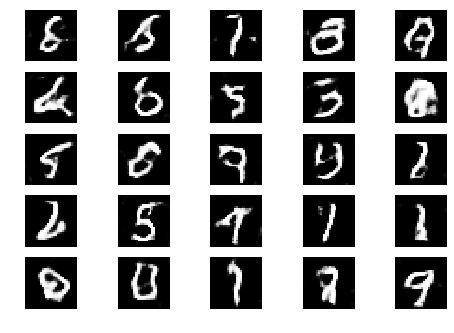

2801 [D loss: 0.605613, acc.: 67.19%] [G loss: 1.546126]
2802 [D loss: 0.668039, acc.: 57.81%] [G loss: 1.334175]
2803 [D loss: 0.596785, acc.: 67.19%] [G loss: 1.359009]
2804 [D loss: 0.583536, acc.: 67.19%] [G loss: 1.646240]
2805 [D loss: 0.539147, acc.: 71.88%] [G loss: 1.287933]
2806 [D loss: 0.588457, acc.: 75.00%] [G loss: 1.314802]
2807 [D loss: 0.630593, acc.: 71.88%] [G loss: 1.127723]
2808 [D loss: 0.733584, acc.: 53.12%] [G loss: 1.378370]
2809 [D loss: 0.590922, acc.: 70.31%] [G loss: 1.175147]
2810 [D loss: 0.532220, acc.: 75.00%] [G loss: 1.622169]
2811 [D loss: 0.649868, acc.: 56.25%] [G loss: 1.280285]
2812 [D loss: 0.612530, acc.: 60.94%] [G loss: 1.411727]
2813 [D loss: 0.603271, acc.: 68.75%] [G loss: 1.303680]
2814 [D loss: 0.654457, acc.: 67.19%] [G loss: 1.479295]
2815 [D loss: 0.732655, acc.: 56.25%] [G loss: 1.346245]
2816 [D loss: 0.489984, acc.: 79.69%] [G loss: 1.398812]
2817 [D loss: 0.588793, acc.: 64.06%] [G loss: 1.181164]
2818 [D loss: 0.667226, acc.: 6

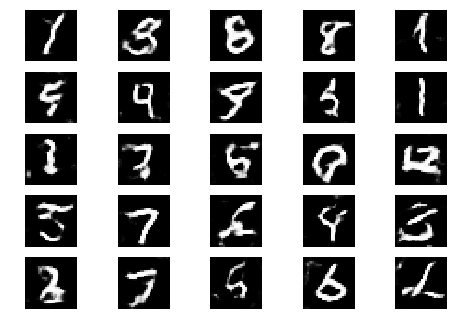

2851 [D loss: 0.663226, acc.: 56.25%] [G loss: 1.490051]
2852 [D loss: 0.642871, acc.: 71.88%] [G loss: 1.406771]
2853 [D loss: 0.858603, acc.: 48.44%] [G loss: 1.500398]
2854 [D loss: 0.433971, acc.: 82.81%] [G loss: 1.709935]
2855 [D loss: 0.642476, acc.: 62.50%] [G loss: 1.361053]
2856 [D loss: 0.669493, acc.: 67.19%] [G loss: 1.413349]
2857 [D loss: 0.469825, acc.: 78.12%] [G loss: 1.396581]
2858 [D loss: 0.461199, acc.: 75.00%] [G loss: 1.578474]
2859 [D loss: 0.618723, acc.: 56.25%] [G loss: 1.479374]
2860 [D loss: 0.602859, acc.: 67.19%] [G loss: 1.345813]
2861 [D loss: 0.383200, acc.: 87.50%] [G loss: 1.243455]
2862 [D loss: 0.413384, acc.: 87.50%] [G loss: 1.909009]
2863 [D loss: 0.644693, acc.: 60.94%] [G loss: 1.126930]
2864 [D loss: 0.592174, acc.: 70.31%] [G loss: 1.192897]
2865 [D loss: 0.449543, acc.: 81.25%] [G loss: 1.568927]
2866 [D loss: 0.534313, acc.: 73.44%] [G loss: 1.538929]
2867 [D loss: 0.587761, acc.: 65.62%] [G loss: 1.517643]
2868 [D loss: 0.504734, acc.: 7

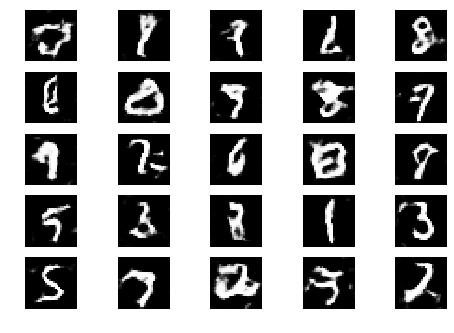

2901 [D loss: 0.635457, acc.: 60.94%] [G loss: 1.551072]
2902 [D loss: 0.584371, acc.: 67.19%] [G loss: 1.309896]
2903 [D loss: 0.675948, acc.: 56.25%] [G loss: 1.361449]
2904 [D loss: 0.586058, acc.: 68.75%] [G loss: 1.476171]
2905 [D loss: 0.752337, acc.: 43.75%] [G loss: 1.179667]
2906 [D loss: 0.423276, acc.: 79.69%] [G loss: 1.531671]
2907 [D loss: 0.644167, acc.: 56.25%] [G loss: 1.320312]
2908 [D loss: 0.687737, acc.: 59.38%] [G loss: 1.546445]
2909 [D loss: 0.626982, acc.: 68.75%] [G loss: 1.325932]
2910 [D loss: 0.605943, acc.: 62.50%] [G loss: 1.480895]
2911 [D loss: 0.789148, acc.: 43.75%] [G loss: 1.482674]
2912 [D loss: 0.620244, acc.: 65.62%] [G loss: 1.366780]
2913 [D loss: 0.683904, acc.: 64.06%] [G loss: 1.547429]
2914 [D loss: 0.635018, acc.: 56.25%] [G loss: 1.241286]
2915 [D loss: 0.949962, acc.: 43.75%] [G loss: 1.221513]
2916 [D loss: 0.538469, acc.: 71.88%] [G loss: 1.342848]
2917 [D loss: 0.498492, acc.: 81.25%] [G loss: 1.428996]
2918 [D loss: 0.659499, acc.: 5

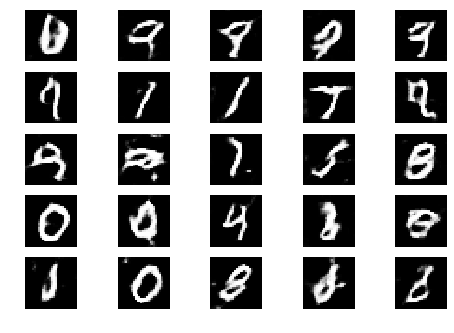

2951 [D loss: 0.698178, acc.: 54.69%] [G loss: 1.492759]
2952 [D loss: 0.710026, acc.: 54.69%] [G loss: 1.263914]
2953 [D loss: 0.728960, acc.: 57.81%] [G loss: 1.268473]
2954 [D loss: 0.822446, acc.: 43.75%] [G loss: 1.415087]
2955 [D loss: 0.616189, acc.: 65.62%] [G loss: 1.081779]
2956 [D loss: 0.614294, acc.: 71.88%] [G loss: 1.563987]
2957 [D loss: 0.686214, acc.: 56.25%] [G loss: 1.582385]
2958 [D loss: 0.881281, acc.: 46.88%] [G loss: 1.310495]
2959 [D loss: 0.641340, acc.: 64.06%] [G loss: 1.823395]
2960 [D loss: 0.530286, acc.: 76.56%] [G loss: 1.149886]
2961 [D loss: 0.634519, acc.: 62.50%] [G loss: 1.313923]
2962 [D loss: 0.728275, acc.: 51.56%] [G loss: 1.464074]
2963 [D loss: 0.554209, acc.: 75.00%] [G loss: 1.591491]
2964 [D loss: 0.474061, acc.: 82.81%] [G loss: 1.762006]
2965 [D loss: 0.709568, acc.: 54.69%] [G loss: 1.082865]
2966 [D loss: 0.737350, acc.: 57.81%] [G loss: 1.422415]
2967 [D loss: 0.636795, acc.: 60.94%] [G loss: 0.978490]
2968 [D loss: 0.464329, acc.: 8

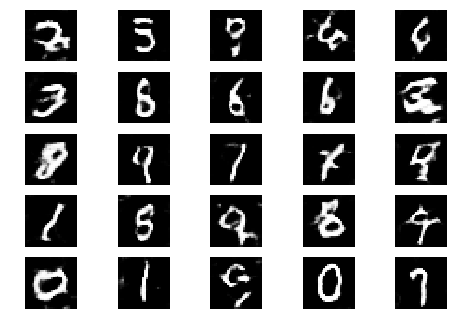

3001 [D loss: 0.526398, acc.: 78.12%] [G loss: 1.489180]
3002 [D loss: 0.713090, acc.: 50.00%] [G loss: 1.406823]
3003 [D loss: 0.657283, acc.: 64.06%] [G loss: 1.350491]
3004 [D loss: 0.603729, acc.: 60.94%] [G loss: 1.275763]
3005 [D loss: 0.837594, acc.: 46.88%] [G loss: 1.469433]
3006 [D loss: 0.529997, acc.: 73.44%] [G loss: 1.593372]
3007 [D loss: 0.545719, acc.: 71.88%] [G loss: 1.551878]
3008 [D loss: 0.670724, acc.: 57.81%] [G loss: 1.091817]
3009 [D loss: 0.728780, acc.: 51.56%] [G loss: 1.250617]
3010 [D loss: 0.574923, acc.: 67.19%] [G loss: 1.344905]
3011 [D loss: 0.574866, acc.: 71.88%] [G loss: 1.521823]
3012 [D loss: 0.800986, acc.: 54.69%] [G loss: 1.439454]
3013 [D loss: 0.784192, acc.: 51.56%] [G loss: 0.853315]
3014 [D loss: 0.686104, acc.: 57.81%] [G loss: 1.404290]
3015 [D loss: 0.528967, acc.: 76.56%] [G loss: 2.113139]
3016 [D loss: 0.629267, acc.: 68.75%] [G loss: 1.543088]
3017 [D loss: 0.612828, acc.: 70.31%] [G loss: 1.708806]
3018 [D loss: 0.620219, acc.: 6

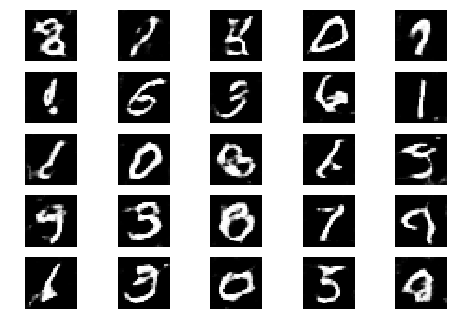

3051 [D loss: 0.638437, acc.: 56.25%] [G loss: 1.508768]
3052 [D loss: 0.661127, acc.: 57.81%] [G loss: 0.971429]
3053 [D loss: 0.677450, acc.: 56.25%] [G loss: 1.157525]
3054 [D loss: 0.446620, acc.: 82.81%] [G loss: 1.519634]
3055 [D loss: 0.591378, acc.: 67.19%] [G loss: 1.570406]
3056 [D loss: 0.625604, acc.: 70.31%] [G loss: 1.234037]
3057 [D loss: 0.492420, acc.: 75.00%] [G loss: 1.304783]
3058 [D loss: 0.525623, acc.: 78.12%] [G loss: 1.464211]
3059 [D loss: 0.453135, acc.: 78.12%] [G loss: 1.948031]
3060 [D loss: 0.812231, acc.: 56.25%] [G loss: 1.079449]
3061 [D loss: 0.618577, acc.: 68.75%] [G loss: 1.303315]
3062 [D loss: 0.588782, acc.: 68.75%] [G loss: 1.631176]
3063 [D loss: 0.643803, acc.: 62.50%] [G loss: 1.226315]
3064 [D loss: 0.569608, acc.: 60.94%] [G loss: 1.411688]
3065 [D loss: 0.632350, acc.: 65.62%] [G loss: 1.147586]
3066 [D loss: 0.678137, acc.: 60.94%] [G loss: 1.597542]
3067 [D loss: 0.592389, acc.: 70.31%] [G loss: 1.271019]
3068 [D loss: 0.671567, acc.: 5

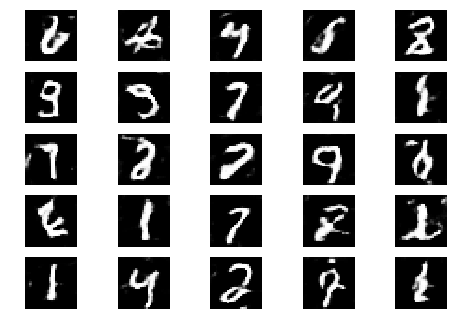

3101 [D loss: 0.720821, acc.: 59.38%] [G loss: 1.273512]
3102 [D loss: 0.578467, acc.: 65.62%] [G loss: 1.300431]
3103 [D loss: 0.474244, acc.: 78.12%] [G loss: 1.226238]
3104 [D loss: 0.572034, acc.: 68.75%] [G loss: 0.964093]
3105 [D loss: 0.583737, acc.: 70.31%] [G loss: 1.359168]
3106 [D loss: 0.471211, acc.: 79.69%] [G loss: 1.471883]
3107 [D loss: 0.517632, acc.: 76.56%] [G loss: 1.342893]
3108 [D loss: 0.609415, acc.: 70.31%] [G loss: 1.562125]
3109 [D loss: 0.700459, acc.: 54.69%] [G loss: 1.103590]
3110 [D loss: 0.524070, acc.: 70.31%] [G loss: 1.178409]
3111 [D loss: 0.702363, acc.: 53.12%] [G loss: 1.106979]
3112 [D loss: 0.664783, acc.: 67.19%] [G loss: 1.042008]
3113 [D loss: 0.542989, acc.: 73.44%] [G loss: 1.297790]
3114 [D loss: 0.452951, acc.: 82.81%] [G loss: 1.895900]
3115 [D loss: 0.677128, acc.: 59.38%] [G loss: 0.990721]
3116 [D loss: 0.757081, acc.: 54.69%] [G loss: 1.307140]
3117 [D loss: 0.450577, acc.: 84.38%] [G loss: 1.879452]
3118 [D loss: 0.472653, acc.: 8

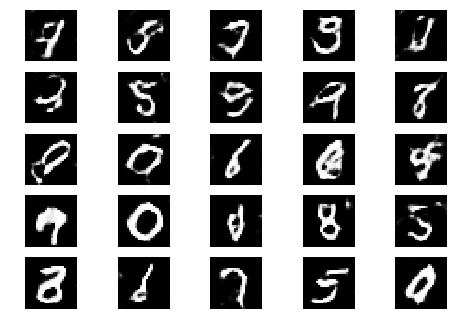

3151 [D loss: 0.565814, acc.: 71.88%] [G loss: 1.278763]
3152 [D loss: 0.578253, acc.: 73.44%] [G loss: 1.501433]
3153 [D loss: 0.622696, acc.: 65.62%] [G loss: 1.279982]
3154 [D loss: 0.509447, acc.: 76.56%] [G loss: 1.351228]
3155 [D loss: 0.647290, acc.: 60.94%] [G loss: 1.442778]
3156 [D loss: 0.764887, acc.: 51.56%] [G loss: 1.280004]
3157 [D loss: 0.591689, acc.: 73.44%] [G loss: 1.302409]
3158 [D loss: 0.602469, acc.: 68.75%] [G loss: 1.667500]
3159 [D loss: 0.628710, acc.: 64.06%] [G loss: 1.065646]
3160 [D loss: 0.546651, acc.: 76.56%] [G loss: 1.356488]
3161 [D loss: 0.725420, acc.: 56.25%] [G loss: 1.735292]
3162 [D loss: 0.640276, acc.: 59.38%] [G loss: 1.682315]
3163 [D loss: 0.684107, acc.: 59.38%] [G loss: 1.467986]
3164 [D loss: 0.574058, acc.: 62.50%] [G loss: 1.279327]
3165 [D loss: 0.849039, acc.: 46.88%] [G loss: 1.103971]
3166 [D loss: 0.691379, acc.: 57.81%] [G loss: 1.197041]
3167 [D loss: 0.608646, acc.: 68.75%] [G loss: 1.356439]
3168 [D loss: 0.524859, acc.: 7

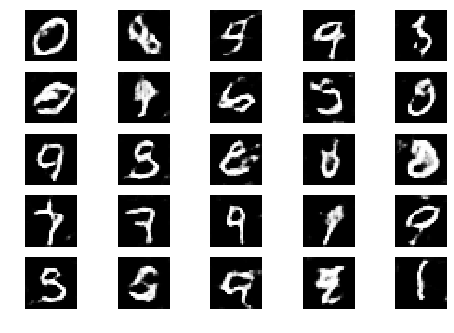

3201 [D loss: 0.410022, acc.: 87.50%] [G loss: 1.710226]
3202 [D loss: 0.646011, acc.: 67.19%] [G loss: 1.463528]
3203 [D loss: 0.530856, acc.: 76.56%] [G loss: 1.373424]
3204 [D loss: 0.665045, acc.: 65.62%] [G loss: 1.539025]
3205 [D loss: 0.620171, acc.: 64.06%] [G loss: 1.741759]
3206 [D loss: 0.517733, acc.: 71.88%] [G loss: 1.867729]
3207 [D loss: 0.430915, acc.: 85.94%] [G loss: 1.758982]
3208 [D loss: 0.571497, acc.: 75.00%] [G loss: 1.477887]
3209 [D loss: 0.739343, acc.: 53.12%] [G loss: 1.351990]
3210 [D loss: 0.491031, acc.: 78.12%] [G loss: 1.284604]
3211 [D loss: 0.444554, acc.: 85.94%] [G loss: 1.408968]
3212 [D loss: 0.640136, acc.: 68.75%] [G loss: 1.248340]
3213 [D loss: 0.627088, acc.: 64.06%] [G loss: 1.182268]
3214 [D loss: 0.637551, acc.: 64.06%] [G loss: 1.295981]
3215 [D loss: 0.468127, acc.: 78.12%] [G loss: 1.472419]
3216 [D loss: 0.451932, acc.: 71.88%] [G loss: 1.478248]
3217 [D loss: 0.713392, acc.: 54.69%] [G loss: 1.312331]
3218 [D loss: 0.564340, acc.: 6

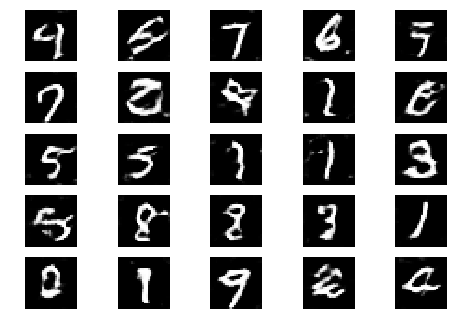

3251 [D loss: 0.531817, acc.: 75.00%] [G loss: 1.329631]
3252 [D loss: 0.656439, acc.: 67.19%] [G loss: 1.549657]
3253 [D loss: 0.664264, acc.: 62.50%] [G loss: 1.284159]
3254 [D loss: 0.478659, acc.: 78.12%] [G loss: 1.485824]
3255 [D loss: 0.592429, acc.: 59.38%] [G loss: 0.977009]
3256 [D loss: 0.730339, acc.: 60.94%] [G loss: 0.848661]
3257 [D loss: 0.639951, acc.: 62.50%] [G loss: 1.550528]
3258 [D loss: 0.668679, acc.: 57.81%] [G loss: 1.486900]
3259 [D loss: 0.608878, acc.: 60.94%] [G loss: 1.198768]
3260 [D loss: 0.777770, acc.: 50.00%] [G loss: 1.402956]
3261 [D loss: 0.661252, acc.: 59.38%] [G loss: 1.722558]
3262 [D loss: 0.647892, acc.: 59.38%] [G loss: 1.151167]
3263 [D loss: 0.607100, acc.: 64.06%] [G loss: 1.243217]
3264 [D loss: 0.517458, acc.: 70.31%] [G loss: 1.213690]
3265 [D loss: 0.740785, acc.: 53.12%] [G loss: 1.136312]
3266 [D loss: 0.538508, acc.: 68.75%] [G loss: 1.180436]
3267 [D loss: 0.730022, acc.: 65.62%] [G loss: 1.072376]
3268 [D loss: 0.587480, acc.: 7

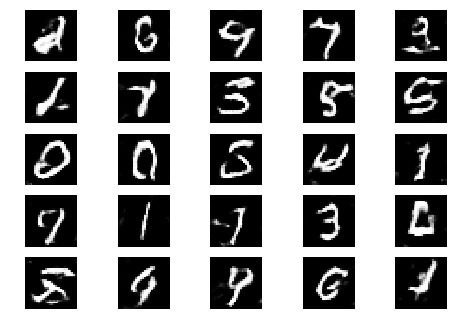

3301 [D loss: 0.664901, acc.: 65.62%] [G loss: 1.364239]
3302 [D loss: 0.676152, acc.: 60.94%] [G loss: 1.801107]
3303 [D loss: 0.587264, acc.: 60.94%] [G loss: 1.400020]
3304 [D loss: 0.550568, acc.: 76.56%] [G loss: 1.487013]
3305 [D loss: 0.770274, acc.: 54.69%] [G loss: 1.083521]
3306 [D loss: 0.613784, acc.: 68.75%] [G loss: 1.794495]
3307 [D loss: 0.713764, acc.: 60.94%] [G loss: 1.339867]
3308 [D loss: 0.716984, acc.: 54.69%] [G loss: 1.638833]
3309 [D loss: 0.650402, acc.: 60.94%] [G loss: 1.571411]
3310 [D loss: 0.657266, acc.: 65.62%] [G loss: 1.429288]
3311 [D loss: 0.541915, acc.: 68.75%] [G loss: 1.651274]
3312 [D loss: 0.660691, acc.: 70.31%] [G loss: 1.179071]
3313 [D loss: 0.670466, acc.: 62.50%] [G loss: 1.270451]
3314 [D loss: 0.548043, acc.: 70.31%] [G loss: 1.928778]
3315 [D loss: 0.842001, acc.: 53.12%] [G loss: 1.179756]
3316 [D loss: 0.676130, acc.: 62.50%] [G loss: 1.120949]
3317 [D loss: 0.513583, acc.: 70.31%] [G loss: 1.275388]
3318 [D loss: 0.761672, acc.: 5

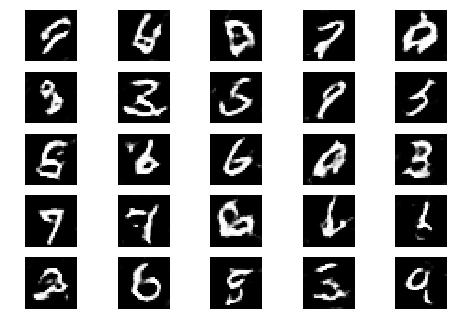

3351 [D loss: 0.828325, acc.: 42.19%] [G loss: 1.144007]
3352 [D loss: 0.698012, acc.: 57.81%] [G loss: 1.442018]
3353 [D loss: 0.672568, acc.: 59.38%] [G loss: 1.735205]
3354 [D loss: 0.698316, acc.: 56.25%] [G loss: 1.101678]
3355 [D loss: 0.698156, acc.: 64.06%] [G loss: 1.431169]
3356 [D loss: 0.647406, acc.: 67.19%] [G loss: 1.318289]
3357 [D loss: 0.697178, acc.: 60.94%] [G loss: 1.141525]
3358 [D loss: 0.671622, acc.: 59.38%] [G loss: 1.308342]
3359 [D loss: 0.513523, acc.: 75.00%] [G loss: 1.336627]
3360 [D loss: 0.560571, acc.: 71.88%] [G loss: 1.068633]
3361 [D loss: 0.635345, acc.: 65.62%] [G loss: 1.079086]
3362 [D loss: 0.666207, acc.: 65.62%] [G loss: 1.472017]
3363 [D loss: 0.482043, acc.: 78.12%] [G loss: 1.313380]
3364 [D loss: 0.484988, acc.: 81.25%] [G loss: 1.389849]
3365 [D loss: 0.729877, acc.: 60.94%] [G loss: 1.364626]
3366 [D loss: 0.523214, acc.: 73.44%] [G loss: 1.619435]
3367 [D loss: 0.483564, acc.: 79.69%] [G loss: 1.239657]
3368 [D loss: 0.592264, acc.: 7

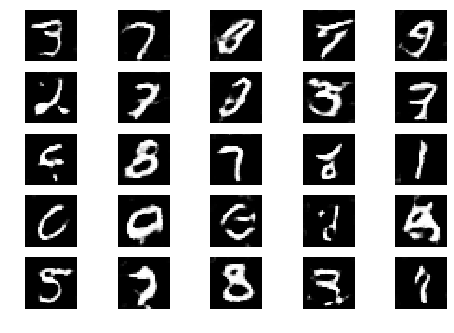

3401 [D loss: 0.733432, acc.: 50.00%] [G loss: 1.212155]
3402 [D loss: 0.613761, acc.: 64.06%] [G loss: 1.039010]
3403 [D loss: 0.506001, acc.: 75.00%] [G loss: 1.766281]
3404 [D loss: 0.599945, acc.: 64.06%] [G loss: 1.737245]
3405 [D loss: 0.397086, acc.: 81.25%] [G loss: 1.800138]
3406 [D loss: 0.636211, acc.: 67.19%] [G loss: 1.446845]
3407 [D loss: 0.424447, acc.: 87.50%] [G loss: 1.716134]
3408 [D loss: 0.534981, acc.: 76.56%] [G loss: 1.420219]
3409 [D loss: 0.785718, acc.: 48.44%] [G loss: 0.861915]
3410 [D loss: 0.561938, acc.: 67.19%] [G loss: 1.366597]
3411 [D loss: 0.607139, acc.: 68.75%] [G loss: 1.170767]
3412 [D loss: 0.508444, acc.: 75.00%] [G loss: 1.442051]
3413 [D loss: 0.639421, acc.: 68.75%] [G loss: 1.156824]
3414 [D loss: 0.594876, acc.: 67.19%] [G loss: 1.645881]
3415 [D loss: 0.631730, acc.: 70.31%] [G loss: 1.198450]
3416 [D loss: 0.585744, acc.: 71.88%] [G loss: 1.504217]
3417 [D loss: 0.639089, acc.: 64.06%] [G loss: 1.590317]
3418 [D loss: 0.638917, acc.: 6

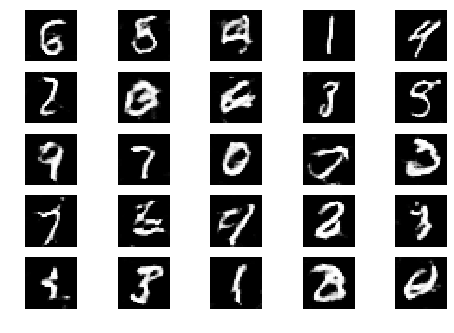

3451 [D loss: 0.715542, acc.: 59.38%] [G loss: 1.545507]
3452 [D loss: 0.545794, acc.: 76.56%] [G loss: 1.406004]
3453 [D loss: 0.564899, acc.: 71.88%] [G loss: 1.434273]
3454 [D loss: 0.526094, acc.: 71.88%] [G loss: 1.521291]
3455 [D loss: 0.503216, acc.: 81.25%] [G loss: 1.629539]
3456 [D loss: 0.700682, acc.: 51.56%] [G loss: 1.314148]
3457 [D loss: 0.472726, acc.: 78.12%] [G loss: 1.351064]
3458 [D loss: 0.525898, acc.: 75.00%] [G loss: 1.312098]
3459 [D loss: 0.752744, acc.: 50.00%] [G loss: 1.324351]
3460 [D loss: 0.618583, acc.: 65.62%] [G loss: 1.285074]
3461 [D loss: 0.756328, acc.: 51.56%] [G loss: 1.626287]
3462 [D loss: 0.473102, acc.: 79.69%] [G loss: 1.253515]
3463 [D loss: 0.632695, acc.: 67.19%] [G loss: 1.597187]
3464 [D loss: 0.442370, acc.: 81.25%] [G loss: 1.534432]
3465 [D loss: 0.641414, acc.: 60.94%] [G loss: 1.778647]
3466 [D loss: 0.515081, acc.: 79.69%] [G loss: 1.444796]
3467 [D loss: 0.637798, acc.: 60.94%] [G loss: 1.428355]
3468 [D loss: 0.616606, acc.: 6

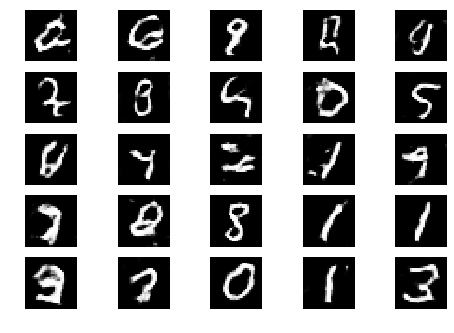

3501 [D loss: 0.606348, acc.: 62.50%] [G loss: 1.632598]
3502 [D loss: 0.753936, acc.: 56.25%] [G loss: 1.239910]
3503 [D loss: 0.753484, acc.: 54.69%] [G loss: 1.335913]
3504 [D loss: 0.525833, acc.: 79.69%] [G loss: 1.331326]
3505 [D loss: 0.684836, acc.: 54.69%] [G loss: 1.351394]
3506 [D loss: 0.660532, acc.: 56.25%] [G loss: 1.514833]
3507 [D loss: 0.535665, acc.: 73.44%] [G loss: 1.375779]
3508 [D loss: 0.633848, acc.: 65.62%] [G loss: 1.688393]
3509 [D loss: 0.755492, acc.: 59.38%] [G loss: 1.185280]
3510 [D loss: 0.522868, acc.: 75.00%] [G loss: 1.301450]
3511 [D loss: 0.670653, acc.: 62.50%] [G loss: 1.135994]
3512 [D loss: 0.493345, acc.: 79.69%] [G loss: 1.197956]
3513 [D loss: 0.593418, acc.: 62.50%] [G loss: 1.380440]
3514 [D loss: 0.544663, acc.: 73.44%] [G loss: 1.429299]
3515 [D loss: 0.626075, acc.: 64.06%] [G loss: 1.318687]
3516 [D loss: 0.579047, acc.: 64.06%] [G loss: 1.155063]
3517 [D loss: 0.674331, acc.: 59.38%] [G loss: 1.224443]
3518 [D loss: 0.679132, acc.: 6

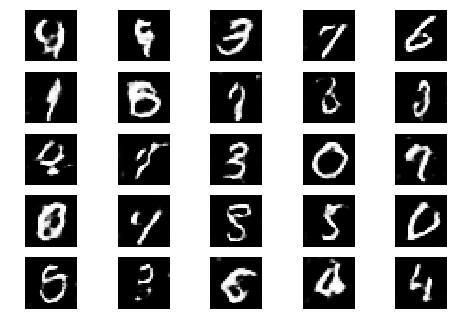

3551 [D loss: 0.647330, acc.: 62.50%] [G loss: 0.959845]
3552 [D loss: 0.578299, acc.: 71.88%] [G loss: 1.197961]
3553 [D loss: 0.653905, acc.: 59.38%] [G loss: 1.212698]
3554 [D loss: 0.556427, acc.: 78.12%] [G loss: 1.174184]
3555 [D loss: 0.624199, acc.: 65.62%] [G loss: 1.515905]
3556 [D loss: 0.731126, acc.: 51.56%] [G loss: 1.266243]
3557 [D loss: 0.723742, acc.: 57.81%] [G loss: 1.713674]
3558 [D loss: 0.654718, acc.: 59.38%] [G loss: 1.736404]
3559 [D loss: 0.575989, acc.: 75.00%] [G loss: 1.609102]
3560 [D loss: 0.482370, acc.: 84.38%] [G loss: 1.354534]
3561 [D loss: 0.598982, acc.: 65.62%] [G loss: 1.443295]
3562 [D loss: 0.707908, acc.: 56.25%] [G loss: 1.200863]
3563 [D loss: 0.574632, acc.: 67.19%] [G loss: 1.306672]
3564 [D loss: 0.574078, acc.: 70.31%] [G loss: 1.371491]
3565 [D loss: 0.516981, acc.: 75.00%] [G loss: 1.464974]
3566 [D loss: 0.566794, acc.: 67.19%] [G loss: 1.366684]
3567 [D loss: 0.548373, acc.: 68.75%] [G loss: 1.462154]
3568 [D loss: 0.498049, acc.: 7

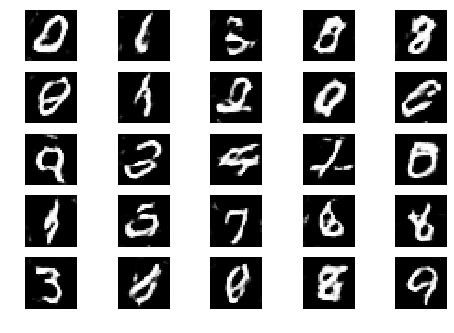

3601 [D loss: 0.755580, acc.: 50.00%] [G loss: 1.353503]
3602 [D loss: 0.693610, acc.: 60.94%] [G loss: 1.578301]
3603 [D loss: 0.566685, acc.: 70.31%] [G loss: 1.415505]
3604 [D loss: 0.468569, acc.: 75.00%] [G loss: 1.699672]
3605 [D loss: 0.594170, acc.: 73.44%] [G loss: 1.588027]
3606 [D loss: 0.561593, acc.: 67.19%] [G loss: 1.385848]
3607 [D loss: 0.553552, acc.: 75.00%] [G loss: 1.697736]
3608 [D loss: 0.802153, acc.: 53.12%] [G loss: 1.551084]
3609 [D loss: 0.422228, acc.: 82.81%] [G loss: 1.835823]
3610 [D loss: 0.676214, acc.: 62.50%] [G loss: 1.609068]
3611 [D loss: 0.643958, acc.: 59.38%] [G loss: 1.230776]
3612 [D loss: 0.523791, acc.: 70.31%] [G loss: 1.399380]
3613 [D loss: 0.503402, acc.: 70.31%] [G loss: 1.466536]
3614 [D loss: 0.745587, acc.: 51.56%] [G loss: 1.826765]
3615 [D loss: 0.594267, acc.: 68.75%] [G loss: 1.592150]
3616 [D loss: 0.627000, acc.: 65.62%] [G loss: 1.530287]
3617 [D loss: 0.742220, acc.: 57.81%] [G loss: 1.241587]
3618 [D loss: 0.415298, acc.: 8

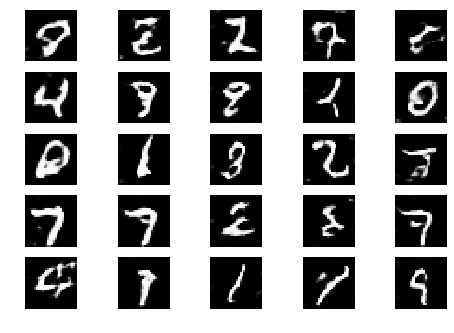

3651 [D loss: 0.798594, acc.: 50.00%] [G loss: 1.121675]
3652 [D loss: 0.728699, acc.: 59.38%] [G loss: 1.078814]
3653 [D loss: 0.532596, acc.: 75.00%] [G loss: 0.978910]
3654 [D loss: 0.451699, acc.: 82.81%] [G loss: 1.388706]
3655 [D loss: 0.699142, acc.: 59.38%] [G loss: 1.415192]
3656 [D loss: 0.637790, acc.: 65.62%] [G loss: 1.455947]
3657 [D loss: 0.856209, acc.: 42.19%] [G loss: 1.157489]
3658 [D loss: 0.732221, acc.: 57.81%] [G loss: 1.519898]
3659 [D loss: 0.701938, acc.: 67.19%] [G loss: 1.536630]
3660 [D loss: 0.691458, acc.: 62.50%] [G loss: 1.502296]
3661 [D loss: 0.498834, acc.: 78.12%] [G loss: 1.201606]
3662 [D loss: 0.582656, acc.: 71.88%] [G loss: 1.286287]
3663 [D loss: 0.605976, acc.: 62.50%] [G loss: 1.935696]
3664 [D loss: 0.516255, acc.: 82.81%] [G loss: 1.198237]
3665 [D loss: 0.515309, acc.: 70.31%] [G loss: 1.398969]
3666 [D loss: 0.526091, acc.: 76.56%] [G loss: 1.145805]
3667 [D loss: 0.740420, acc.: 62.50%] [G loss: 1.342865]
3668 [D loss: 0.578114, acc.: 5

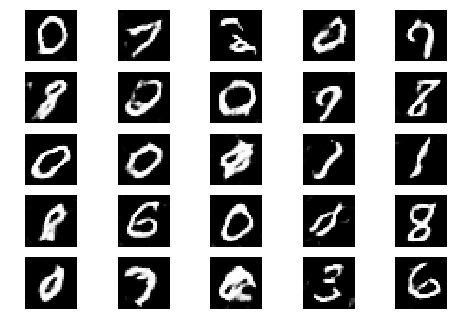

3701 [D loss: 0.607411, acc.: 65.62%] [G loss: 1.352486]
3702 [D loss: 0.737798, acc.: 53.12%] [G loss: 1.438620]
3703 [D loss: 0.576814, acc.: 64.06%] [G loss: 1.283771]
3704 [D loss: 0.608510, acc.: 65.62%] [G loss: 1.550404]
3705 [D loss: 0.417819, acc.: 82.81%] [G loss: 1.502131]
3706 [D loss: 0.547020, acc.: 68.75%] [G loss: 1.545161]
3707 [D loss: 0.663544, acc.: 57.81%] [G loss: 1.075146]
3708 [D loss: 0.599002, acc.: 65.62%] [G loss: 1.561808]
3709 [D loss: 0.593059, acc.: 68.75%] [G loss: 1.293396]
3710 [D loss: 0.732073, acc.: 56.25%] [G loss: 1.325130]
3711 [D loss: 0.560139, acc.: 71.88%] [G loss: 0.889916]
3712 [D loss: 0.468440, acc.: 78.12%] [G loss: 0.981508]
3713 [D loss: 0.677213, acc.: 70.31%] [G loss: 1.131119]
3714 [D loss: 0.700211, acc.: 59.38%] [G loss: 1.633489]
3715 [D loss: 0.526525, acc.: 73.44%] [G loss: 1.402439]
3716 [D loss: 0.585308, acc.: 70.31%] [G loss: 1.563018]
3717 [D loss: 0.636693, acc.: 67.19%] [G loss: 1.029087]
3718 [D loss: 0.866830, acc.: 4

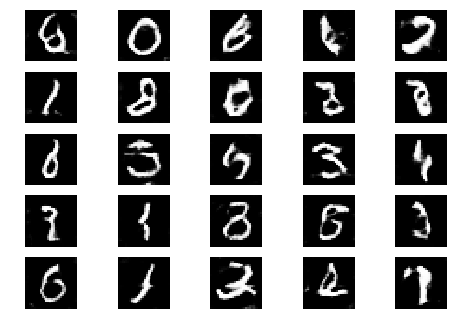

3751 [D loss: 0.917486, acc.: 48.44%] [G loss: 1.045889]
3752 [D loss: 0.747832, acc.: 53.12%] [G loss: 1.294391]
3753 [D loss: 0.651881, acc.: 67.19%] [G loss: 1.325619]
3754 [D loss: 0.505079, acc.: 76.56%] [G loss: 1.556816]
3755 [D loss: 0.761533, acc.: 48.44%] [G loss: 1.509991]
3756 [D loss: 0.638697, acc.: 67.19%] [G loss: 1.231878]
3757 [D loss: 0.666692, acc.: 59.38%] [G loss: 1.320064]
3758 [D loss: 0.598530, acc.: 65.62%] [G loss: 1.536784]
3759 [D loss: 0.512763, acc.: 73.44%] [G loss: 1.498772]
3760 [D loss: 0.778609, acc.: 56.25%] [G loss: 1.054763]
3761 [D loss: 0.586998, acc.: 67.19%] [G loss: 1.236531]
3762 [D loss: 0.588175, acc.: 70.31%] [G loss: 1.519838]
3763 [D loss: 0.596818, acc.: 76.56%] [G loss: 1.548506]
3764 [D loss: 0.544908, acc.: 68.75%] [G loss: 1.554208]
3765 [D loss: 0.609716, acc.: 64.06%] [G loss: 1.472565]
3766 [D loss: 0.652654, acc.: 59.38%] [G loss: 1.196795]
3767 [D loss: 0.529476, acc.: 71.88%] [G loss: 1.334116]
3768 [D loss: 0.566548, acc.: 6

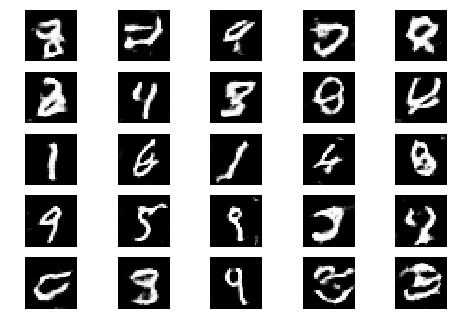

3801 [D loss: 0.506570, acc.: 78.12%] [G loss: 1.577615]
3802 [D loss: 0.490590, acc.: 79.69%] [G loss: 1.554891]
3803 [D loss: 0.766047, acc.: 48.44%] [G loss: 1.141316]
3804 [D loss: 0.798959, acc.: 50.00%] [G loss: 1.122796]
3805 [D loss: 0.693078, acc.: 60.94%] [G loss: 1.298326]
3806 [D loss: 0.524202, acc.: 78.12%] [G loss: 1.523751]
3807 [D loss: 0.609879, acc.: 64.06%] [G loss: 1.481258]
3808 [D loss: 0.543063, acc.: 75.00%] [G loss: 1.344780]
3809 [D loss: 0.536250, acc.: 73.44%] [G loss: 1.332778]
3810 [D loss: 0.807583, acc.: 51.56%] [G loss: 0.965310]
3811 [D loss: 0.563457, acc.: 68.75%] [G loss: 1.099432]
3812 [D loss: 0.427399, acc.: 84.38%] [G loss: 1.300658]
3813 [D loss: 0.529103, acc.: 75.00%] [G loss: 1.469095]
3814 [D loss: 0.664836, acc.: 68.75%] [G loss: 1.154572]
3815 [D loss: 0.665982, acc.: 62.50%] [G loss: 0.935010]
3816 [D loss: 0.604103, acc.: 64.06%] [G loss: 1.081901]
3817 [D loss: 0.553367, acc.: 73.44%] [G loss: 1.278897]
3818 [D loss: 0.621547, acc.: 6

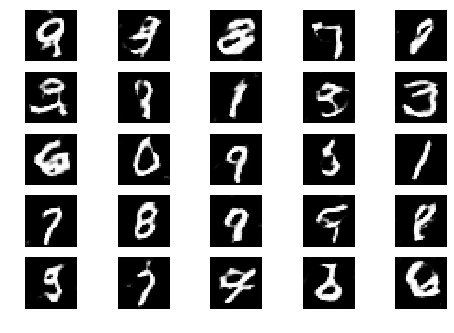

3851 [D loss: 0.781843, acc.: 53.12%] [G loss: 1.260438]
3852 [D loss: 0.452287, acc.: 79.69%] [G loss: 1.191297]
3853 [D loss: 0.554989, acc.: 68.75%] [G loss: 1.501504]
3854 [D loss: 0.697826, acc.: 57.81%] [G loss: 1.411411]
3855 [D loss: 0.618954, acc.: 67.19%] [G loss: 1.400651]
3856 [D loss: 0.581556, acc.: 71.88%] [G loss: 1.499134]
3857 [D loss: 0.627341, acc.: 57.81%] [G loss: 1.269303]
3858 [D loss: 0.448889, acc.: 79.69%] [G loss: 1.425262]
3859 [D loss: 0.756953, acc.: 59.38%] [G loss: 1.065199]
3860 [D loss: 0.530791, acc.: 73.44%] [G loss: 1.876228]
3861 [D loss: 0.618283, acc.: 62.50%] [G loss: 1.988796]
3862 [D loss: 0.712393, acc.: 57.81%] [G loss: 1.518254]
3863 [D loss: 0.756722, acc.: 46.88%] [G loss: 1.361142]
3864 [D loss: 0.595349, acc.: 73.44%] [G loss: 1.642633]
3865 [D loss: 0.656924, acc.: 67.19%] [G loss: 1.913526]
3866 [D loss: 0.523247, acc.: 73.44%] [G loss: 1.525795]
3867 [D loss: 0.533121, acc.: 79.69%] [G loss: 1.200718]
3868 [D loss: 0.573645, acc.: 6

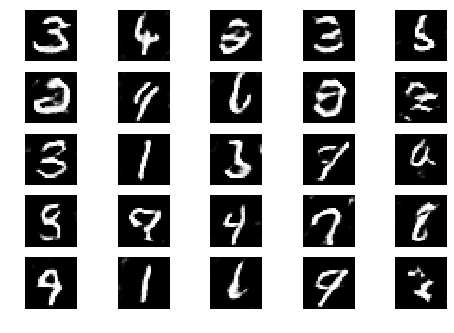

3901 [D loss: 0.390780, acc.: 90.62%] [G loss: 1.757809]
3902 [D loss: 0.507195, acc.: 75.00%] [G loss: 1.491204]
3903 [D loss: 0.389744, acc.: 84.38%] [G loss: 1.432712]
3904 [D loss: 0.575554, acc.: 73.44%] [G loss: 1.657338]
3905 [D loss: 0.519067, acc.: 73.44%] [G loss: 1.581819]
3906 [D loss: 0.811768, acc.: 42.19%] [G loss: 1.328119]
3907 [D loss: 0.476471, acc.: 85.94%] [G loss: 1.616910]
3908 [D loss: 0.596138, acc.: 65.62%] [G loss: 1.464514]
3909 [D loss: 0.655815, acc.: 60.94%] [G loss: 1.496266]
3910 [D loss: 0.526884, acc.: 71.88%] [G loss: 1.747561]
3911 [D loss: 0.534964, acc.: 67.19%] [G loss: 1.760904]
3912 [D loss: 0.777570, acc.: 53.12%] [G loss: 1.513699]
3913 [D loss: 0.688334, acc.: 60.94%] [G loss: 1.143567]
3914 [D loss: 0.579278, acc.: 68.75%] [G loss: 1.432927]
3915 [D loss: 0.498113, acc.: 78.12%] [G loss: 1.810923]
3916 [D loss: 0.740433, acc.: 53.12%] [G loss: 1.390584]
3917 [D loss: 0.565061, acc.: 70.31%] [G loss: 1.080470]
3918 [D loss: 0.602311, acc.: 6

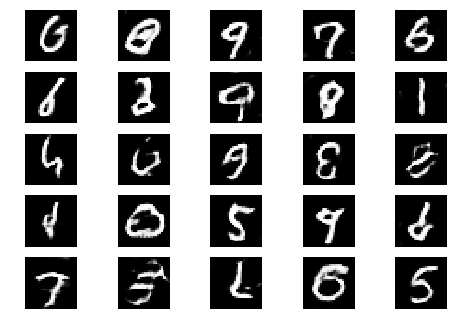

3951 [D loss: 0.639146, acc.: 68.75%] [G loss: 1.505799]
3952 [D loss: 0.520669, acc.: 78.12%] [G loss: 1.559139]
3953 [D loss: 0.562890, acc.: 71.88%] [G loss: 1.261894]
3954 [D loss: 0.630411, acc.: 67.19%] [G loss: 1.185383]
3955 [D loss: 0.372142, acc.: 87.50%] [G loss: 1.609001]
3956 [D loss: 0.409924, acc.: 82.81%] [G loss: 1.266039]
3957 [D loss: 0.616195, acc.: 64.06%] [G loss: 1.512312]
3958 [D loss: 0.653649, acc.: 60.94%] [G loss: 1.433951]
3959 [D loss: 0.657808, acc.: 67.19%] [G loss: 1.335521]
3960 [D loss: 0.645737, acc.: 67.19%] [G loss: 1.295941]
3961 [D loss: 0.683903, acc.: 64.06%] [G loss: 1.274291]
3962 [D loss: 0.638136, acc.: 60.94%] [G loss: 1.396946]
3963 [D loss: 0.434321, acc.: 81.25%] [G loss: 1.083563]
3964 [D loss: 0.632820, acc.: 64.06%] [G loss: 1.119433]
3965 [D loss: 0.613000, acc.: 71.88%] [G loss: 1.424261]
3966 [D loss: 0.515520, acc.: 76.56%] [G loss: 1.220078]
3967 [D loss: 0.726593, acc.: 57.81%] [G loss: 1.075245]
3968 [D loss: 0.546392, acc.: 7

In [0]:
if __name__ == '__main__':
    dcgan = DCGAN()
    dcgan.train(epochs=4000, batch_size=32, save_interval=50)

In [0]:
random_noise = Input(shape=(100,))

In [0]:
print (random_noise)

Tensor("input_1:0", shape=(?, 100), dtype=float32)


In [0]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()  # 训练集数据 训练集标签 测试集 测试集标签

In [0]:
print (X_train.shape)
print (X_test.shape)
print (Y_train.shape)
print (Y_test.shape)

(60000, 28, 28)
(10000, 28, 28)
(60000,)
(10000,)


In [0]:
X_train_batch = np.expand_dims(X_train, axis = 3) # 由于keras 只能按批处理数据，因此需要把单个数据提高一个维度 girl_batch = np.expand_dims(girl,axis=0) #数据维度由（575,607,3）变为（1,575,607,3）rint

In [0]:
idx = np.random.randint(0, X_train.shape[0], 128) # 随机取batch_size的index 
print (idx)

imgs = X_train[idx]

print (imgs.shape) # 取random index的batch

[13591 11265 57658 41878 17435 44046 45769 42883  2461 23725 16429   778
 39347 53179 53464   397 49513 10437 18933 43116 54899 12201 49080 54647
 28516 26958 42910 35127 24606 18316  6507 26002 37777 26203 59671 12356
 39683  3448 34483  8830 35604 55625 42305 57113 29650 56800 36780 18511
  5784 24219 11172 28182 33966 24499  5533  2454 53434 27199  8402 25314
 38648 12202 44264 38982 43490 10975 56099  2056  5732 38117  9673 16301
  3684 42126 58552 26914 26290 58128 38293 19999 47892 36001 35667 56469
  5136 26280 20691 47511 39589 41617  9843  7097 22494  6312 35575 37891
 30209 22096 23720 33497 53753 11791 22707 41172 33634 47357  6419 50978
 38251 46085 18101 47954 33531 25049  6629 22150 39272 54776 50376 12325
 37816 14836 46813 30603  7752 41240 19922 48519]
(128, 28, 28)


In [0]:
#@title 默认标题文本
noise = np.random.normal(0, 1, (128, 100)) # 产生batch_size的 noise location: 0 scale: 1
print (noise.shape)

print (noise[0])

(128, 100)
[-0.91981874  0.6984419  -0.75681865 -0.71901233  0.89458406 -0.58689573
 -1.63641609  2.6897968   0.03550669  0.21183512 -0.68620983  0.06658723
  0.5256765  -0.49272033  0.1897798   0.90777171  1.40231934  0.29983599
  0.1499615  -0.06738083  0.09018644 -0.50523209 -1.18478297 -2.0582974
 -0.74253351 -0.42037039 -0.85761422 -0.44066901 -0.34404872 -1.30381703
  0.46248667  2.29418041 -0.02848838 -0.13664571  1.64445672  1.02664378
 -0.61315583  0.21783586  0.16187796  0.78708497  0.81806764  0.71298388
 -0.58469337  0.3902347   0.1519971  -1.03546388  0.74733055  1.05733041
  0.54520144 -0.09342772 -0.44739021  1.19949191  0.64399934 -0.18421002
  1.37016472 -0.86645445 -0.50782297 -0.8324573   0.44905531 -0.8617944
  1.24315715 -0.54886712 -1.41907466 -0.57151064 -0.08168646  1.84589445
  1.11111377 -0.48442622 -1.15251046 -0.14745758 -0.60455876 -1.51878916
 -0.06352084  0.25892307 -0.37001763 -1.22511298  0.48190512  1.3105576
  1.01730883  0.43457182 -0.27974569 -0.586

In [0]:
model = Sequential()

model.add(Dense(128 * 10 * 30, activation="relu", input_dim=100))
model.add(Reshape((10, 30, 128)))
model.add(UpSampling2D())
model.add(Conv2D(128, kernel_size=3, padding="same"))
model.add(BatchNormalization(momentum=0.8))
model.add(Activation("relu"))
model.add(UpSampling2D())
model.add(Conv2D(64, kernel_size=3, padding="same"))
model.add(BatchNormalization(momentum=0.8))
model.add(Activation("relu"))
model.add(Conv2D(1, kernel_size=3, padding="same"))
model.add(Activation("tanh"))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 38400)             3878400   
_________________________________________________________________
reshape_2 (Reshape)          (None, 10, 30, 128)       0         
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 20, 60, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 20, 60, 128)       147584    
_________________________________________________________________
batch_normalization_3 (Batch (None, 20, 60, 128)       512       
_________________________________________________________________
activation_4 (Activation)    (None, 20, 60, 128)       0         
_________________________________________________________________
up_sampling2d_4 (UpSampling2 (None, 40, 120, 128)      0         
__________